In [1]:
#Load all the essential packages for the analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import config_declining_disruption as config
import tqdm
from tqdm.auto import tqdm

import gc

/opt/anaconda3/envs/disruption/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Check whether required packages are installed: pandas==1.4.3 numpy==1.23.1 matplotlib==3.5.2 seaborn==0.11.2

#We strongly recommend to use the same versions of the packages as used by Park et al. (2023) for their original paper.
#If you use different versions of the packages, the plotting mistake in seaborn might not be visible and the latest versions
#of matplotlib might cause error messages in the figure plots below.

print("pandas: ", pd.__version__)
print("matplotlib: ", matplotlib.__version__)
print("seaborn: ", sns.__version__)
print("numpy: ", np.__version__)

pandas:  1.4.3
matplotlib:  3.5.2
seaborn:  0.11.2
numpy:  1.23.1


In [4]:
#Install the packages used by Park et al. (2023) if the correct versions are not installed
#%pip install pandas==1.4.3 numpy==1.23.1 matplotlib==3.5.2 seaborn==0.11.2 

In [4]:
#Font
plt.rcParams["font.family"] = "Arial"
plt.rcParams["text.usetex"] = True

## Load Patent Data

First, download the original data provided by Park et al. (2023) under the following link: https://zenodo.org/records/7258379. Then insert the patentsview_analytical_df.csv.gz in the data folder.

In [55]:
#Load patentsview_df
patentsview_df = pd.read_csv(config.DATA_PATH+"patentsview_analytical_df.csv.gz",
                             dtype={"field_nber_category_id":str},
                             low_memory=False)

#Process the patent data as done in the original notebook patent_analyses.ipynb provided by Park et al. (2023)

#Format field names as done in the original notebook
patentsview_df = patentsview_df.replace({"field_nber_category_id": config.NBER_CATEGORY_ID_NAMES})
#Drop small and missing category_ids for visuals as done in the original notebook
patentsview_df = patentsview_df[~patentsview_df.field_nber_category_id.isnull()]
patentsview_df = patentsview_df[patentsview_df.field_nber_category_id != ""]
patentsview_df = patentsview_df[patentsview_df.field_nber_category_id != "7"]
patentsview_df = patentsview_df[patentsview_df.field_nber_category_id != "Others"]
#Subset years as done in the original notebook
patentsview_df = patentsview_df[(patentsview_df.grant_year >= 1980)
                              & (patentsview_df.grant_year <= 2010)]

patentsview_df.reset_index(drop=True, inplace=True)

## Load Unified Paper Dataset

First, download the original data provided by Park et al. (2023) under the following link: https://zenodo.org/records/7258379. Then insert the unified_cdindex_df.csv.gz and the wos_cdindex_normalized_analytical_df.csv.gz in the data folder. 

In [4]:
#Load the unified_cdindex_df containing data for the six different data sources used in Park et al. (2023)
unified_cdindex_df = pd.read_csv(config.DATA_PATH + "unified_cdindex_df.csv.gz",
                                 low_memory=False)

#Extract the Web of Science data
wos_df=unified_cdindex_df[unified_cdindex_df["source"]=="WoS"]
#Extract the Microsoft Academic Graph data
MAG_df=unified_cdindex_df[unified_cdindex_df["source"]=="MAG"]

# Load SciSciNet - All Doc Types

SciSciNet is publicly available at https://doi.org/10.6084/m9.figshare.c.6076908.v1.

The SciSciNet data source contains 81,901,858 papers and 1,588,739,703 citations that span from 1800 to 2022. We constructed a directed citation network with papers as nodes and citations as edges using the SciSciNet_PaperReferences.tsv. We then calculated the $\mathrm{CD}_5$ index for all papers until 2011 using the definition from Park et al. (2023). We also computed the $\mathrm{CD}_{10}$ index for all papers until 2006 and two normalized variants of the $\mathrm{CD}_5$ index. To allow comparison to the results presented in Park et al. (2023), we focus on the time span between 1944 and 2011. 

To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert the SciSciNet_df.csv and the SciSciNet_df_doctype in the data folder. 

In [5]:
#Load the SciSciNet_df
SciSciNet_df=pd.read_csv(config.DATA_PATH + "SciSciNet_df.csv")

#Load information on the Document Type
SciSciNet_df_doctype=pd.read_csv(config.DATA_PATH + "SciSciNet_df_DocType.csv")
SciSciNet_df.loc[:,"DocType"]=SciSciNet_df_doctype["DocType"]
del SciSciNet_df_doctype
gc.collect()

#Rename NaN Doctype to Not defined
SciSciNet_df['DocType'].fillna('Not defined', inplace=True)

#Convert publication date column to datetime and extract year
SciSciNet_df['year']=pd.to_datetime(SciSciNet_df['publication_date'],format='%Y-%m-%d')
SciSciNet_df['year']=SciSciNet_df['year'].dt.year
SciSciNet_df['year']=SciSciNet_df['year'].astype(int)

#Clean the SciSciNet_df
SciSciNet_df.dropna(subset=["Field_Name", "Team_Size"], inplace=True)

SciSciNet_df.reset_index(drop=True, inplace=True)

To calculate the CD index with a maximum forward citation window we use the precomputed Disruption values by Lin, Z. et al. (2023). These values are only computed for papers with at least one forward citation and at least one reference. To allow comparison with the CD index as used by Park et al. (2023), we impute the values with at least one forward citation and zero references to one and the values with zero forward citations and at least one reference to zero. See also Supplementary Figure S7 in our manuscript. 

In [6]:
#Make new column for cd_max 
SciSciNet_df['cd_max']=SciSciNet_df['Disruption']

#Impute Disruption values for references=0 and forward_citations>0 to one
mask = (SciSciNet_df.references == 0) & (SciSciNet_df.forward_citations > 0)
SciSciNet_df.loc[mask, 'cd_max'] = 1.0

#Impute Disruption values for references>0 and forward_citations=0 to zero
#Note: here, we assume without loss of generality that at least one of the references of the focal paper has been 
#cited at least once after the publication of the focal paper
mask = (SciSciNet_df.references > 0) & (SciSciNet_df.forward_citations == 0)
SciSciNet_df.loc[mask, 'cd_max'] = 0.0

In [7]:
#Calculate the number of data entries when subsetting SciSciNet_df

#Mask to filter DocType to Journal and Conference
mask1=SciSciNet_df['DocType'].isin(['Journal', 'Conference'])

#Mask to filter Field_Name to Humanities: Art, History, and Philosophy
mask2=SciSciNet_df['Field_Name'].isin(['Art', 'History', 'Philosophy'])

#Mask to filter for defined CD_5 values
mask3=SciSciNet_df.cd_5.notna()

mask=mask1 & ~mask2 & mask3
print("Data entries SciSciNet subsetted to Journal and Conference, excluding Humanities: ", mask.sum())

#Mask to filter publication years between 1945 and 2010
mask5=SciSciNet_df['Year']>=1945
mask6=SciSciNet_df['Year']<=2010

mask=mask & mask5 & mask6
print("Data entries SciSciNet subsetted to Journal and Conference, excluding Humanities, between 1945 and 2010: ",mask.sum())

Data entries SciSciNet subsetted to Journal and Conference, excluding Humanities:  34144434
Data entries SciSciNet subsetted to Journal and Conference, excluding Humanities, between 1945 and 2010:  32054558


# Load SciSciNet - Raw Journal Data

SciSciNet is publicly available at https://doi.org/10.6084/m9.figshare.c.6076908.v1.

To compute CD indices with the raw journal data, we first constructed a directed citation network with papers as nodes and citations as edges using the SciSciNet_PaperReferences.tsv. Then, we subsetted the data accordingly to consider 47,460,120 articles published in scientific journals between 1800 and 2016, excluding contributions from art, history, and philosophy, with 780,247,698 citations between them. After that, we calculated the $\mathrm{CD}_5$ index for all papers until 2011 using the definition from Park et al. (2023). We also computed the $\mathrm{CD}_{10}$ index for all papers until 2006 and two normalized variants of the $\mathrm{CD}_5$ index. To allow comparison to the results presented in Park et al. (2023), we focus on the time span between 1944 and 2011. 

To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert the SciSciNet_df_raw_journal_data.csv in the data folder. 

In [8]:
#Load the raw SciSciNet journal data
SciSciNet_df_raw=pd.read_csv(config.DATA_PATH + "SciSciNet_df_raw_journal_data.csv")

#Clean the raw SciSciNet journal data 
SciSciNet_df_raw.dropna(subset=["Field_Name", "Team_Size"], inplace=True)

In [13]:
#Only keep certain columns for further analysis
SciSciNet_df_raw=SciSciNet_df_raw[['PaperID', 'cd_5', 'cd_5_paper_norm', 'cd_5_field_x_year_norm', 'cd_10', 'references', 'forward_citations_5']]
#Rename the columns
SciSciNet_df_raw.columns=['PaperID', 'cd_5_raw', 'cd_5_paper_norm_raw', 'cd_5_field_x_year_norm_raw', 'cd_10_raw','references_raw', 'forward_citations_5_raw']

#Merge SciSciNet_df with SciSciNet_df_raw for easier plotting of the data 
SciSciNet_df=pd.merge(SciSciNet_df, SciSciNet_df_raw, on="PaperID", how="left")

#Create a mask to filter for journal articles that are part of the SciSciNet_df
mask_raw_journal_data=SciSciNet_df.PaperID.isin(SciSciNet_df_raw.PaperID)

#Delete SciSciNet_df_raw to free up memory
del SciSciNet_df_raw
gc.collect()

474

# Supplementary Table S5

Summary statistics of the document types in SciSciNet and its influence on the randomly drawn papers with $\mathrm{CD}_5=1$ and zero references.

To reproduce the table, download the SciSciNet_df_random_sample_final.xlsx under https://zenodo.org/records/10619475 and insert in the data folder.

In [14]:
#Overview of different DocTypes for paper with defined CD index
mask=SciSciNet_df.cd_5.notna()
print(SciSciNet_df[mask].DocType.value_counts())

Journal        32299110
Not defined     2775650
Conference      2303632
Book             911262
Repository       824071
BookChapter      437802
Thesis           336195
Dataset             477
Name: DocType, dtype: int64


In [15]:
#Load random sample of SciSciNet_df
SciSciNet_random_df=pd.read_excel(config.DATA_PATH+"SciSciNet_df_random_sample_final.xlsx")
#Rename NaN Doctype to Not defined
SciSciNet_random_df['DocType'].fillna('Not defined', inplace=True)
#Only keep samples where we had access to PDF 
mask=SciSciNet_random_df.references_in_pdf.notna()
SciSciNet_random_df=SciSciNet_random_df[mask]   

In [16]:
#Summary statistics of random sample
print(SciSciNet_random_df.DocType.value_counts())

Journal        78
Book            9
Not defined     8
Thesis          2
BookChapter     1
Repository      1
Conference      1
Name: DocType, dtype: int64


In [17]:
#Print frequency of papers with references in source document per DocType

for doctype in SciSciNet_random_df.DocType.unique():
    mask1=SciSciNet_random_df['DocType']==doctype
    mask2=SciSciNet_random_df.references_in_pdf!=0
    mask=mask1 & mask2
    print('Frequency of zero references for {}:'.format(doctype), mask.sum()/mask1.sum())
    print('--------------------------------------------------')


Frequency of zero references for Journal: 0.9230769230769231
--------------------------------------------------
Frequency of zero references for Book: 1.0
--------------------------------------------------
Frequency of zero references for Not defined: 0.875
--------------------------------------------------
Frequency of zero references for Thesis: 1.0
--------------------------------------------------
Frequency of zero references for BookChapter: 1.0
--------------------------------------------------
Frequency of zero references for Repository: 1.0
--------------------------------------------------
Frequency of zero references for Conference: 1.0
--------------------------------------------------


# Supplementary Figure S10

The heterogeneity in the SciSciNet data source is stable throughout time.

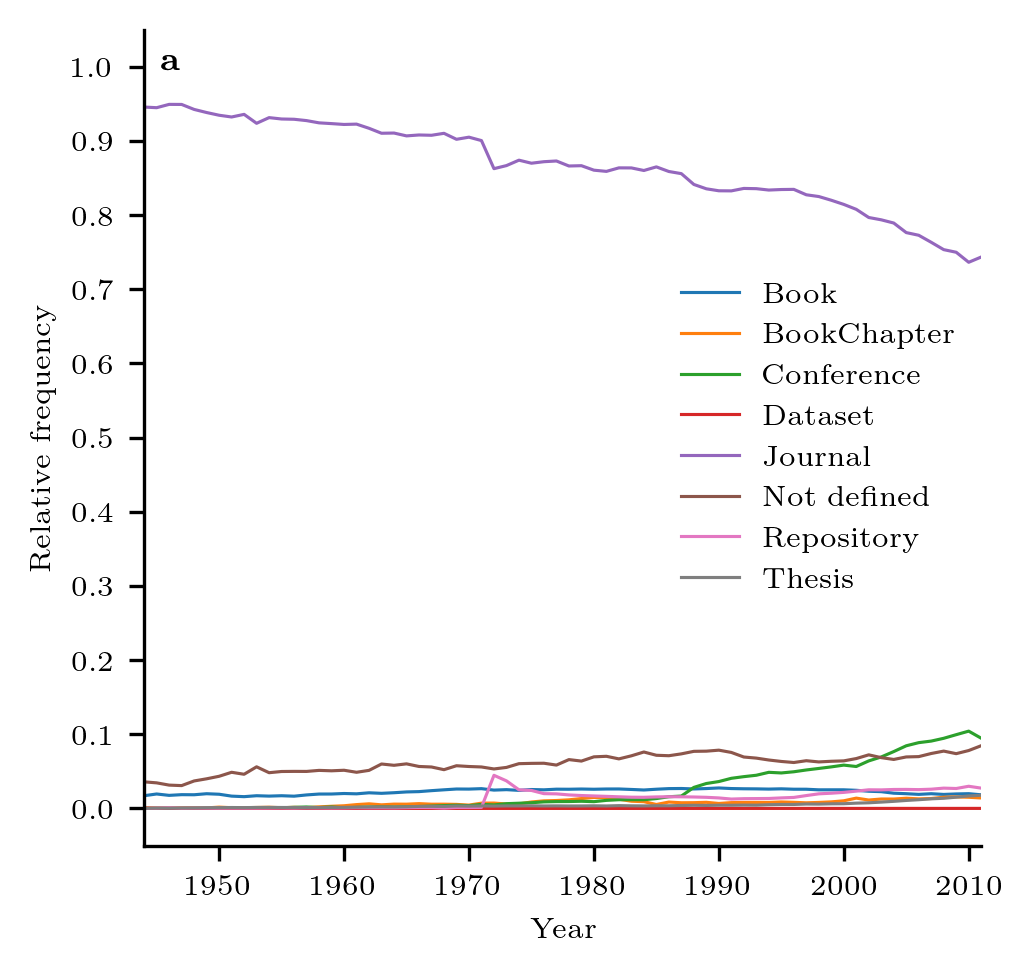

In [ ]:
#Plot the relative frequency of DocTypes per year in SciSciNet_df

Figure, ax = plt.subplot_mosaic([['A']],
                                figsize=(7.08/2,6.69/2),
                                gridspec_kw = {'width_ratios':[1],
                                                 'height_ratios': [1]},
                                dpi = 300
                                )


plt.rcParams['legend.title_fontsize'] = 7

mask=SciSciNet_df.cd_5.notna()
entries_per_year=SciSciNet_df[mask].Year.value_counts().sort_index()
#DocTypes per year
doctypes_per_year=SciSciNet_df[mask].groupby('Year')['DocType'].value_counts().unstack().fillna(0)
#Calculate relative frequencies
relative_frequencies=doctypes_per_year.divide(entries_per_year, axis=0)
#Plot relative frequencies with hue as lineplot
relative_frequencies.plot(kind='line', ax=ax['A'], linewidth=0.75, legend=True)

ax['A'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax['A'].set_ylim(-0.05,1.05)
ax["A"].set_xlabel('Year', fontsize=7)
ax["A"].set_ylabel("Relative frequency", fontsize=7)
xticks=config.PAPER_YEAR_TICKS
ax['A'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
yticks=np.arange(0,1.1,0.1)
ax['A'].set_yticks(yticks, [str(y)[0:3] for y in yticks], fontsize=7)

ax['A'].text(0.02,0.95,r'$\textbf{a}$', transform=ax['A'].transAxes,fontsize = 8)

sns.despine(ax=ax['A'],left=False, bottom=False)

# legend
ax['A'].legend(
    loc='best',
    frameon=False,
    fontsize=7,
)

Figure.tight_layout()
Figure.subplots_adjust(hspace = 0.1,wspace = 0)
Figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_DocType_frequency.pdf', dpi=300)

# Supplementary Figure S16

Across all six data sources used by Park et al. (2023), the absolute magnitude of the peak at CD=1 does not drive the decline in disruption, but its relative decrease does.

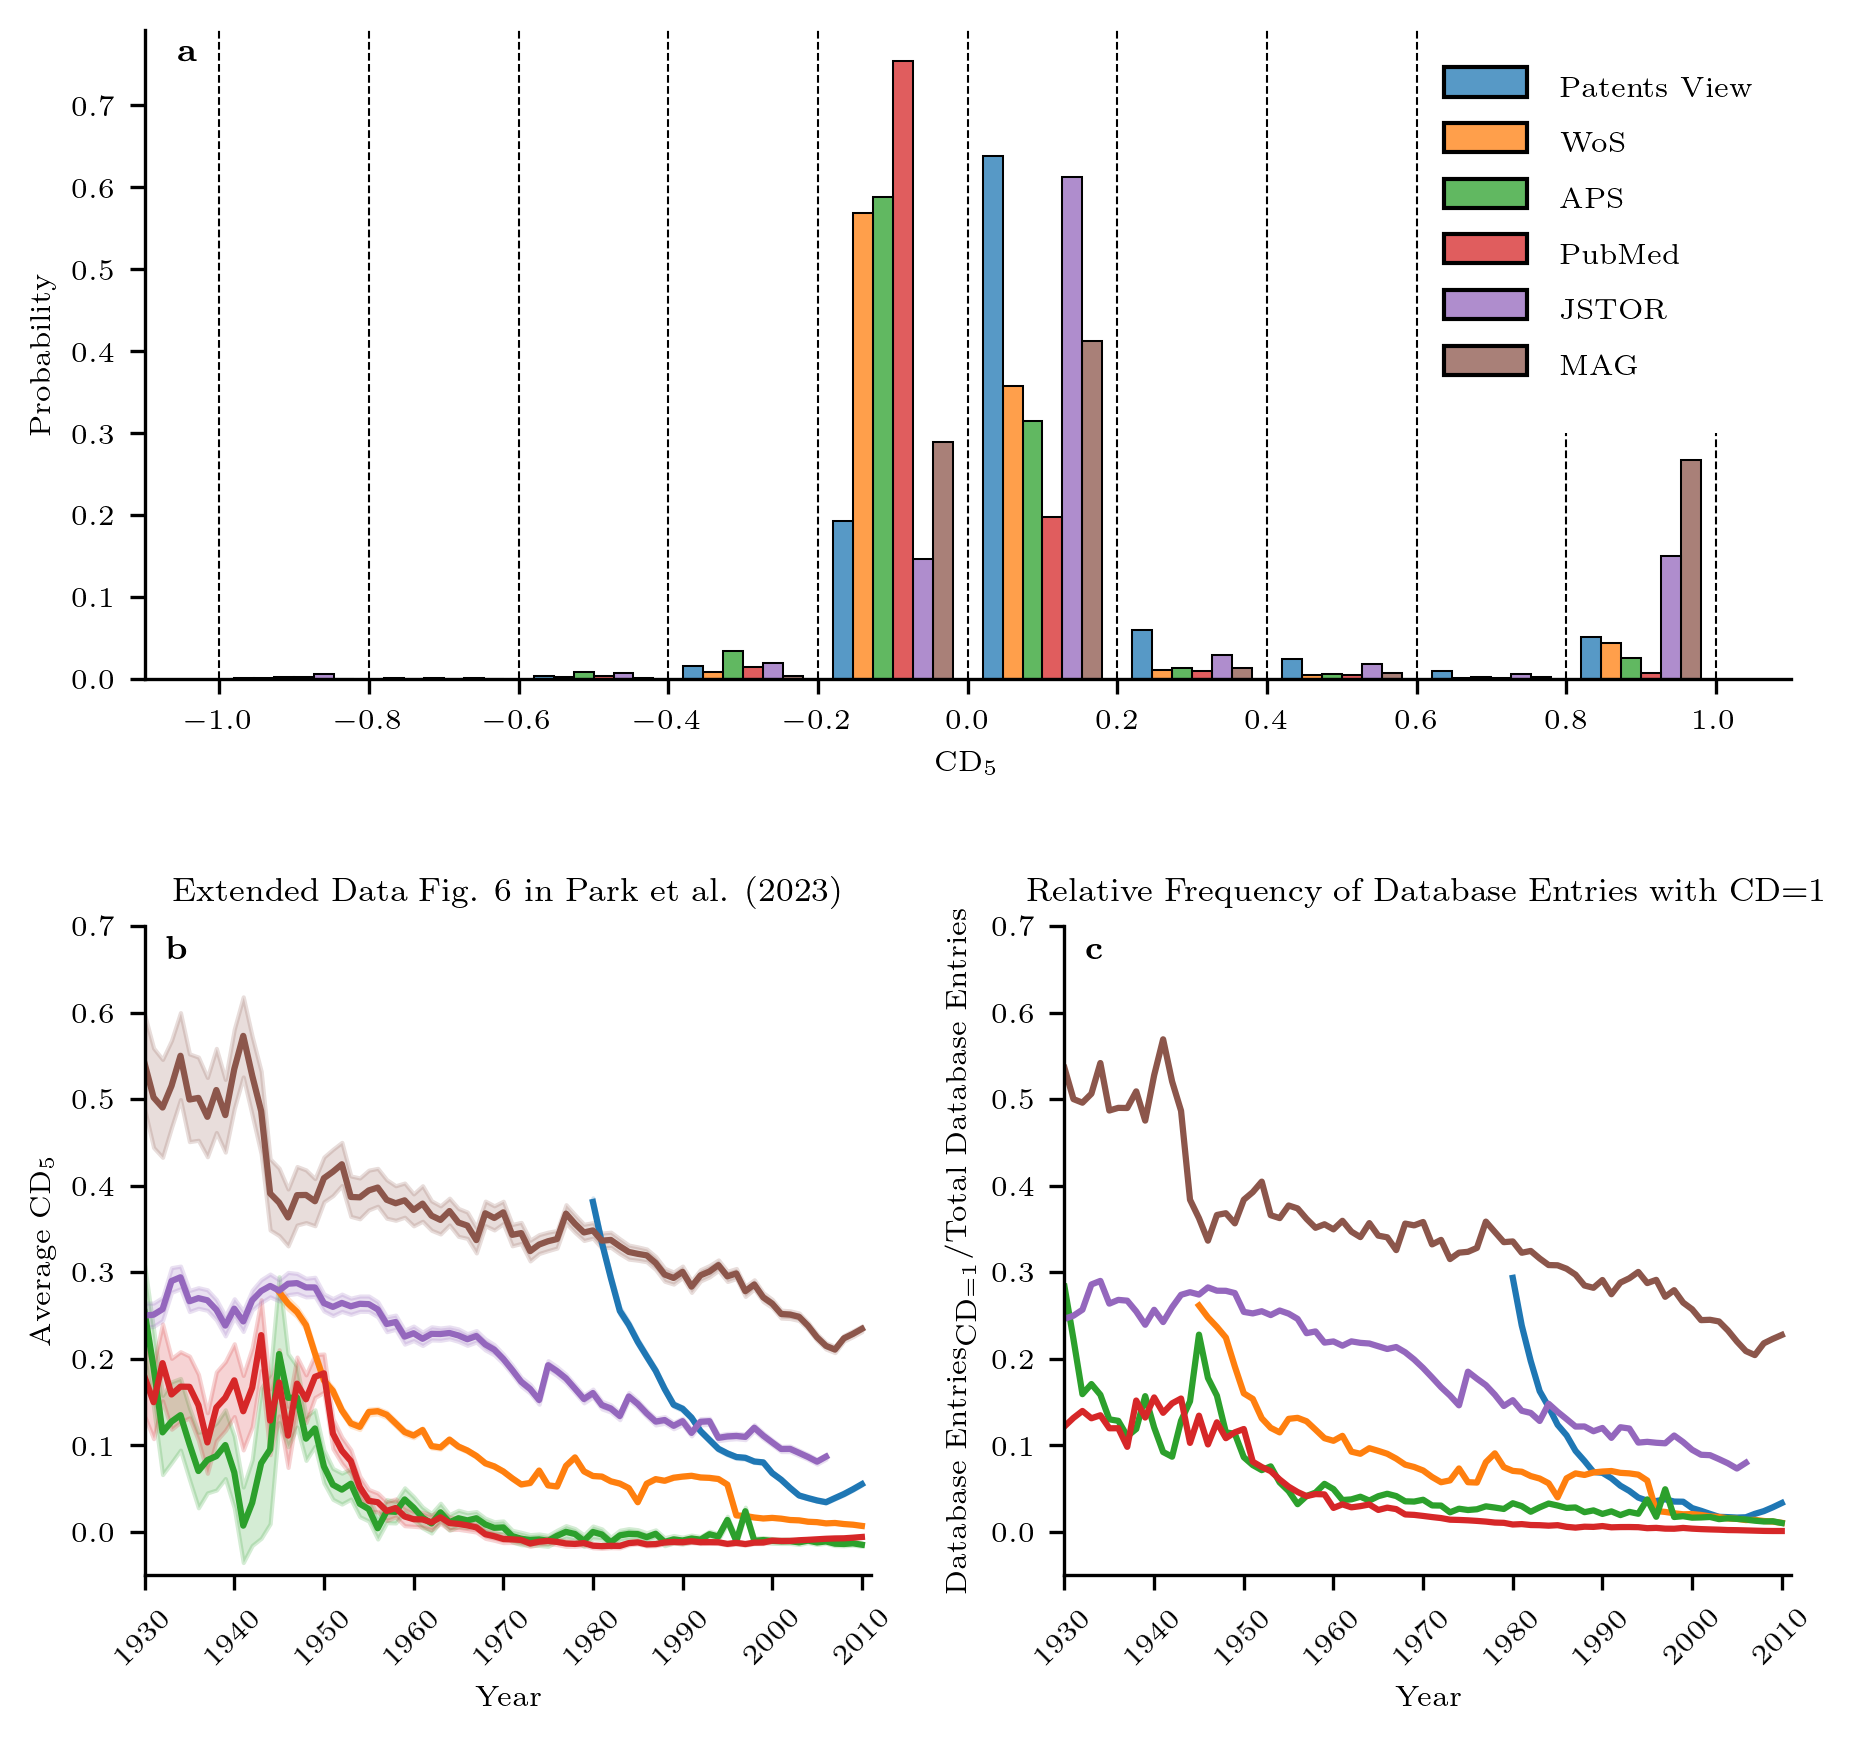

In [ ]:
Figure, ax = plt.subplot_mosaic([
                                ['A', 'A', 'A'],
                                 ['.', '.', '.'],
                                 ['B', '.', 'C']
                                ],
                                figsize=(7.08,6.69),
                                gridspec_kw = {'width_ratios':[1, 0, 1],
                                                 'height_ratios': [1, 0.1, 1]},
                                dpi = 300
                                )
### WARNING: This cell can take some time to run ###

CONFIDENCE_INTERVAL = 95

### RECOMMENDATION: For faster runtime, set CONFIDENCE_INTERVAL to None ### 

HUE_ORDER=['Patents View', 'WoS', 'APS', 'PubMed', 'JSTOR', 'MAG']
plt.rcParams['legend.title_fontsize'] = 7

"""
a: Distribution of CD_5 values for the six data sources
"""

sns.histplot(unified_cdindex_df, 
             x="cd_5", 
             hue="source",
             hue_order=HUE_ORDER,
             multiple='dodge',
             shrink=0.8,
             common_norm=False, 
             stat='probability',
             bins=10, 
             ax=ax['A']
             )

#Plot dotted vertical lines at -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1
for i in [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]:
    ax['A'].axvline(i, color='k', linestyle='--', linewidth=0.5)

# Draw partial vertical lines for 0.8 and 1
for i in [0.8, 1]:
    ax['A'].plot([i, i], [0, 0.3], color='k', linestyle='--', linewidth=0.5)

#Set x-ticks similar to the vertical lines 
xticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1]
ax['A'].set_xticks(xticks)

ax["A"].set_xlabel(r'$\mathrm{CD}_5$', fontsize=7)
ax["A"].set_ylabel("Probability", fontsize=7)
ax['A'].tick_params(axis='both', which='major', labelsize=7)

#Remove title and frameon from legend and set font to 7
ax['A'].get_legend().set_title("")
ax['A'].get_legend().set_frame_on(False)

#Adjust legend font 
for t in ax['A'].get_legend().texts:
    t.set_text(t.get_text())    
    t.set_fontsize(7)
ax['A'].text(0.02,0.95,r'$\textbf{a}$', transform=ax['A'].transAxes,fontsize = 8)

sns.despine(ax=ax['A'],left=False, bottom=False)

""" 
b: Decline of CD_5 for the six data sources
"""

#Plot with no papers and patents removed
lineplot1 = sns.lineplot(data=unified_cdindex_df,
             x="year",
             y="cd_5",
             hue="source",
             hue_order=HUE_ORDER,
             ci=CONFIDENCE_INTERVAL,
             legend = None,
             ax=ax['B'])

ax['B'].set_xlim(config.PATENT_MIN_YEAR, config.PATENT_MAX_YEAR)
x_ticks = [1930, 1940, 1950, 1960, 1970] + config.PATENT_YEAR_TICKS
ax['B'].set_xticks(x_ticks,labels = [str(x) for x in x_ticks],rotation = 45)
ax['B'].set_ylim(-0.05, 0.7)
ax['B'].set_xlabel("Year",fontsize = 7)
ax['B'].set_ylabel("Average $\mathrm{CD}_5$",fontsize = 7)
ax['B'].tick_params(axis='x', labelsize=7)
ax['B'].tick_params(axis='y', labelsize=7)

ax['B'].text(0.03,0.95,r'$\textbf{b}$', transform=ax['B'].transAxes,fontsize = 8)
sns.despine(ax=ax['B'], left=False, bottom=False)

ax['B'].set_title('Extended Data Fig. 6 in Park et al. (2023)', fontsize=8)

"""
c: Relative decrease of CD_5=1 papers for the six data sources
"""

mask = unified_cdindex_df['cd_5'] == 1
df=unified_cdindex_df[mask].groupby(['year', 'source']).size()/unified_cdindex_df.groupby(['year', 'source']).size()
#Convert df to a long format with columns year, source, and relative_ratio
df = df.reset_index(name='relative_ratio')

#Plot the relative decrease of CD_5=1 papers for the six data sources
lineplot2 = sns.lineplot(data=df,
             x="year",
             y="relative_ratio",
             hue="source",
             hue_order=HUE_ORDER,
             ci=None,
             legend = None,
             ax=ax['C'])

ax['C'].set_xlim(config.PATENT_MIN_YEAR, config.PATENT_MAX_YEAR)
x_ticks = [1930, 1940, 1950, 1960, 1970] + config.PATENT_YEAR_TICKS
ax['C'].set_xticks(x_ticks,labels = [str(x) for x in x_ticks],rotation = 45)
ax['C'].set_ylim(-0.05, 0.7)
ax['C'].set_xlabel("Year",fontsize = 7)
ax['C'].set_ylabel(r'$\textrm{Database Entries}_{\textrm{CD} = 1}/\textrm{Total Database Entries}$',fontsize = 7)
ax['C'].tick_params(axis='x', labelsize=7)
ax['C'].tick_params(axis='y', labelsize=7)
ax['C'].set_title('Relative Frequency of Database Entries with CD=1', fontsize=8)

ax['C'].text(0.03,0.95,r'$\textbf{c}$', transform=ax['C'].transAxes,fontsize = 8)
sns.despine(ax=ax['C'], left=False, bottom=False)

Figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_Distribution_DataSources_relative_decrease.pdf')
plt.show()

# Supplementary Figure S9

The document type has no effect on the regression results for SciSciNet

To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert SciSciNet_margins, SciSciNet_residuals_1.npy, SciSciNet_residuals_2.npy, SciSciNet_margins_subset_journal_conference.csv, SciSciNet_residuals_1_subset_journal_conference.npy, SciSciNet_residuals_2_subset_journal_conference.npy in the data folder.

In [19]:
#Load the SciSciNet residuals
residuals_1=np.load(config.DATA_PATH+'SciSciNet_residuals_1.npy') #model 1 in Supplementary Table S1
residuals_2=np.load(config.DATA_PATH+'SciSciNet_residuals_2.npy') #model 2 in Supplementary Table S1
residuals_1_subset_journal_conference=np.load(config.DATA_PATH+'SciSciNet_residuals_1_subset_journal_conference.npy') 
residuals_2_subset_journal_conference=np.load(config.DATA_PATH+'SciSciNet_residuals_2_subset_journal_conference.npy') 
#Add the residuals to the SciSciNet_df dataframe
mask=SciSciNet_df.cd_5.notna()
SciSciNet_df.loc[mask,'residuals_squared_1']=residuals_1**2
SciSciNet_df.loc[mask,'residuals_squared_2']=residuals_2**2
#Add the residuals_X_fields to the SciSciNet_df dataframe
mask1=SciSciNet_df.cd_5.notna()
mask2=SciSciNet_df.DocType.isin(['Journal', 'Conference'])
mask3=SciSciNet_df['Field_Name'].isin(['Art', 'History', 'Philosophy'])
mask=mask1 & mask2 & ~mask3
SciSciNet_df.loc[mask,'residuals_squared_1_subset_journal_conference']=residuals_1_subset_journal_conference**2
SciSciNet_df.loc[mask,'residuals_squared_2_subset_journal_conference']=residuals_2_subset_journal_conference**2
#R2 values for the reference dummies for papers
R2_reference_dummy_papers=[0.15, 0.95, 0.16, 0.17, 0.17, 0.17, 0.17] #calculated in regression_adjustments_sciscinet.ipynb
R2_reference_dummy_papers_subset_journal_conference=[0.16, 0.94, 0.17, 0.17, 0.18, 0.18, 0.18]

In [23]:
SciSciNet_margins=pd.read_csv(config.DATA_PATH+'SciSciNet_margins.csv')
SciSciNet_margins_subset_journal_conference=pd.read_csv(config.DATA_PATH+'SciSciNet_margins_subset_journal_conference.csv')

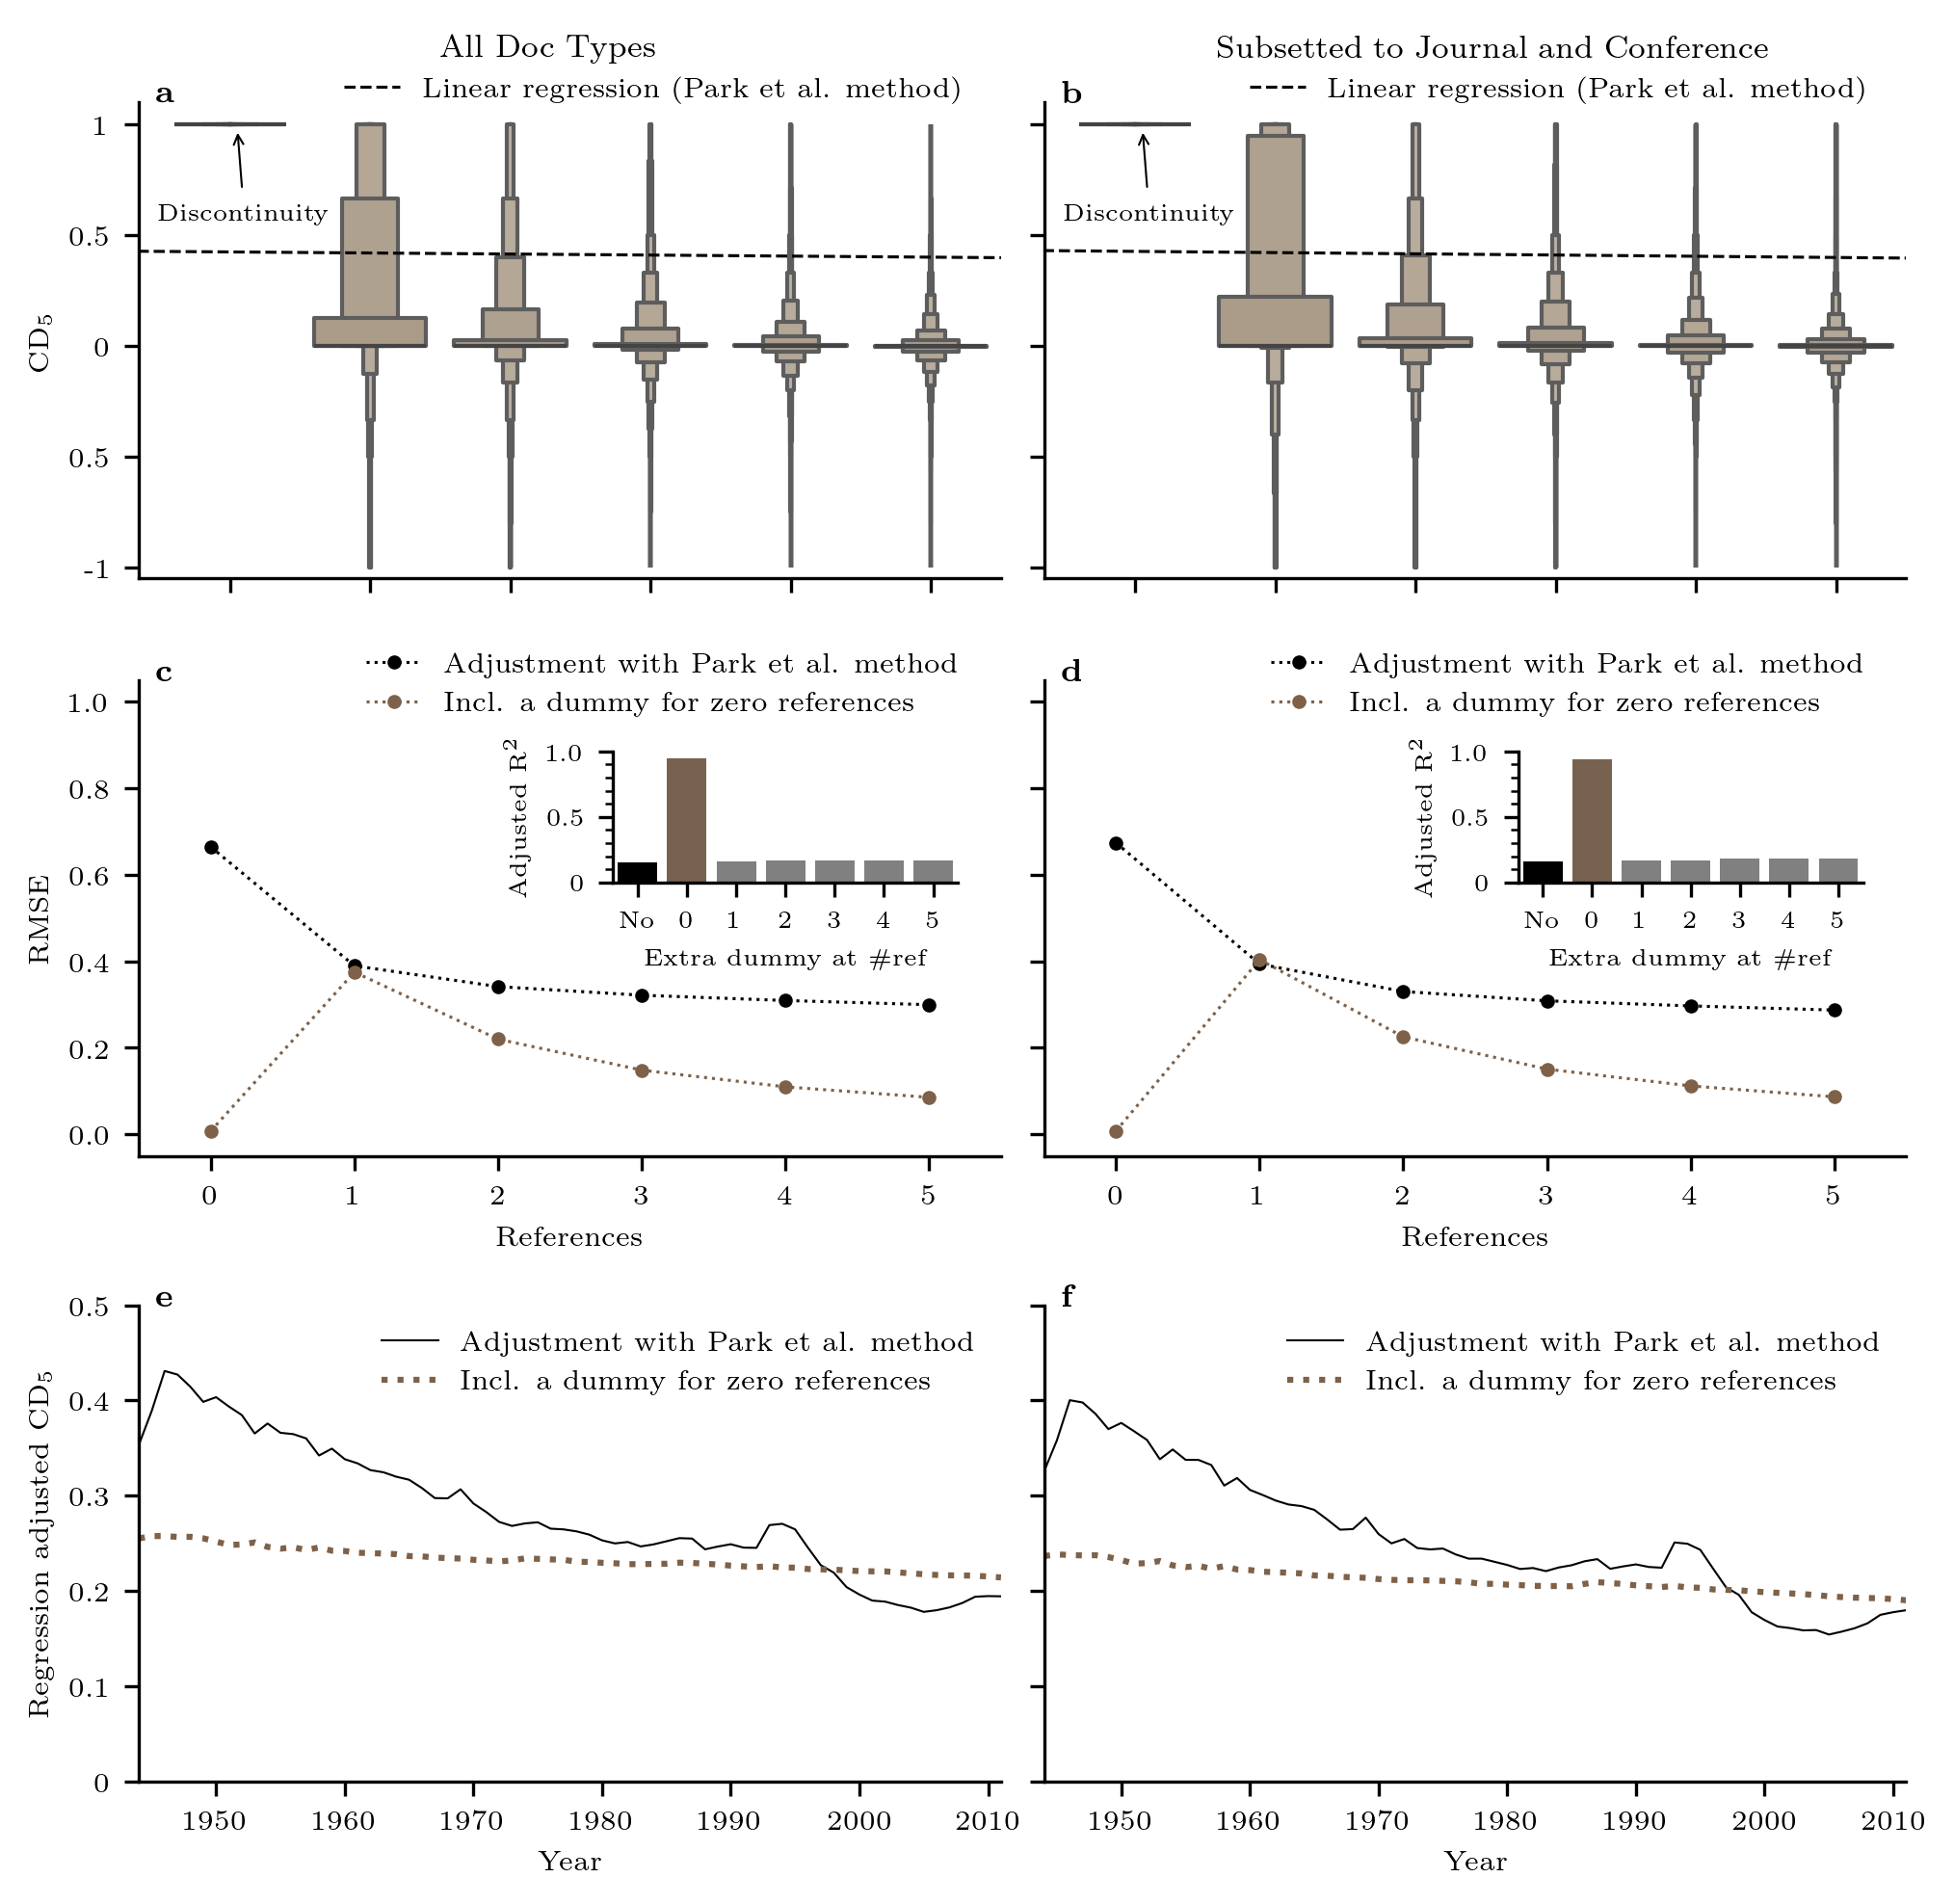

In [ ]:
Figure2, ax2 = plt.subplot_mosaic([['1', '1', '.', '2','2'],
                                   ['A','A', '.', 'B', 'B'],
                                   ['.','.','.','.','.'],
                                   ['C','C','.','D', 'D'],
                                    ['.','.','.','.','.'],
                                   ['E', 'E','.', 'F', 'F']],
                                  figsize=(7.08,6.69),
                                  gridspec_kw = {'width_ratios':[1, 1, 0.1, 1, 1],
                                                 'height_ratios': [0.1, 1, 0.1, 1, 0.2, 1]},
                                                 dpi = 300
                                                 )


plt.rcParams['legend.title_fontsize'] = 7

#---------------------------------------------1---------------------------------------------
ax2['1'].set_axis_off()
ax2['1'].text(0.35,0.4,'All Doc Types', transform=ax2['1'].transAxes,fontsize = 8)

#---------------------------------------------2---------------------------------------------
ax2['2'].set_axis_off()
ax2['2'].text(0.2,0.4,'Subsetted to Journal and Conference', transform=ax2['2'].transAxes,fontsize = 8)

#====================== Discontinuity at zero references =================================== 
"""
a: Distribution of CD index against number of references for all document types  
"""

#Add the regression line y=0.4250995-0.0047266*x=alpha+beta_1*x (see model 1 in Supplementary Table S1)

regplot2=sns.lineplot(x=np.arange(-1, 6, 0.1),
              y=0.4250995-0.0047266*np.arange(-1, 6, 0.1),
              linestyle="--",
              linewidth=0.75,
              color="black",
              ax=ax2["A"]
              )

boxenplot2=sns.boxenplot(
    data=SciSciNet_df[SciSciNet_df["references"] <= 5],
    x="references",
    y="cd_5",
    color="#B09C8599",
    linewidth=1,
    showfliers=True,
    ax=ax2["A"]
)

ax2["A"].set(xlim=(-0.65, 5.5))
ax2["A"].set(ylim=(-1.05, 1.1))
ax2["A"].set_xlabel("", fontsize = 7)
ax2["A"].set_xticks(ticks=[0,1,2,3,4,5], labels=["","","","","",""], fontsize=7)
ax2["A"].set_ylabel(r"$\mathrm{CD}_5$", fontsize = 7)
ax2["A"].set_yticks(ticks=[-1,-0.5,0,0.5,1], labels=["-1","0.5","0","0.5","1"], fontsize=7)
ax2["A"].set_title("")

ax2['A'].text(0.02,1,r'$\textbf{a}$', transform=ax2['A'].transAxes,fontsize = 8)

ax2['A'].annotate('Discontinuity', xy=(0.05, 1), xytext=(0.1, 0.55),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=0.5),
             horizontalalignment='center', verticalalignment='bottom', fontsize=6)

# legend
ax2['A'].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='--', linewidth=0.75,
               markersize=1,
               label='Linear regression (Park et al. method)'
               )
    ],
    loc=(0.225, 0.975),
    frameon=False,
    fontsize=7,
)

sns.despine(ax=ax2["A"],left=False, bottom=False)

del boxenplot2, regplot2
gc.collect()

"""
b: Distribution of CD index against number of references for all Journal and Conference contributions, excl. field of Humanities  
"""

#Add the regression line y=0.4276012-0.0055076*x=alpha+beta_1*x (see model 1 in Supplementary Table S1)

regplot2=sns.lineplot(x=np.arange(-1, 6, 0.1),
              y=0.4276012-0.0055076*np.arange(-1, 6, 0.1),
              linestyle="--",
              linewidth=0.75,
              color="black",
              ax=ax2["B"]
              )

mask1=SciSciNet_df['DocType'].isin(['Journal', 'Conference'])
mask2=SciSciNet_df['Field_Name'].isin(['Art', 'History', 'Philosophy'])
mask3=SciSciNet_df['references'] <= 5
mask=mask1 & ~mask2 & mask3

boxenplot2=sns.boxenplot(
    data=SciSciNet_df[mask],
    x="references",
    y="cd_5",
    color="#B09C8599",
    linewidth=1,
    showfliers=True,
    ax=ax2["B"]
)

ax2["B"].set(xlim=(-0.65, 5.5))
ax2["B"].set(ylim=(-1.05, 1.1))
ax2["B"].set_xlabel("", fontsize = 7)
ax2["B"].set_xticks(ticks=[0,1,2,3,4,5], labels=["","","","","",""], fontsize=7)
ax2["B"].set_ylabel(r"", fontsize = 7)
ax2["B"].set_yticks(ticks=[-1,-0.5,0,0.5,1], labels=["","","","",""], fontsize=7)
ax2["B"].set_title("")

ax2['B'].text(0.02,1,r'$\textbf{b}$', transform=ax2['B'].transAxes,fontsize = 8)

ax2['B'].annotate('Discontinuity', xy=(0.05, 1), xytext=(0.1, 0.55),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=0.5),
             horizontalalignment='center', verticalalignment='bottom', fontsize=6)

# legend
ax2['B'].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='--', linewidth=0.75,
               markersize=1,
               label='Linear regression (Park et al. method)'
               )
    ],
    loc=(0.225, 0.975),
    frameon=False,
    fontsize=7,
)

sns.despine(ax=ax2["B"],left=False, bottom=False)

del boxenplot2, regplot2
gc.collect()

#================================= Regression =================================== 

"""
c: Regression adjustment plot for all document types 
"""

#Calculate mean residuals_squared_1 per number of references
mask=SciSciNet_df["references"] <= 5
rmse_1_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_1'].mean().values)
rmse_1=ax2['C'].errorbar(
                x=np.arange(0, 6, 1),
                y=rmse_1_mean,
                color="black",
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )


#Calculate mean residuals_squared_2 per cited_total
mask=SciSciNet_df["references"] <= 5
rmse_2_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_2'].mean().values)
rmse_2=ax2['C'].errorbar(x=np.arange(0, 6, 1),
                y=rmse_2_mean,
                color='#7E6148FF',
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )

ax2['C'].set_xlabel("References", fontsize=7)
ax2['C'].set(xlim=(-0.5, 5.5))
ax2['C'].set_ylim(-0.05, 1.05)
ax2['C'].set_ylabel('RMSE', fontsize = 7)
ax2['C'].set_xticks(ticks=[0,1,2,3,4,5], labels=[r"0","1","2","3","4","5"], fontsize=7)
yticks=np.arange(0, 1.1, 0.2) 
ax2['C'].set_yticks(ticks=yticks, labels=[str(y)[0:3] for y in yticks], fontsize=7)
ax2['C'].set_title("")
ax2['C'].text(0.02,1,r'$\textbf{c}$', transform=ax2['C'].transAxes,fontsize = 8)

sns.despine(ax=ax2['C'],left=False, bottom=False)

# legend
ax2['C'].legend(
    handles=[
        Line2D([0], [0], color='black', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Incl. a dummy for zero references'),
    ],
    loc=(0.25,0.9),
    frameon=False,
    fontsize=7,
)

del rmse_1, rmse_2
gc.collect()

ax2['C_inset'] = ax2['C'].inset_axes([0.55, 0.575, 0.4, 0.275])

#HUE FOR COLORING THE BARS
HUE=[0, 1, 2, 2, 2, 2, 2]

#Plot the R2_reference_dummy_papers as a line
paper_dummies=sns.barplot(x=np.arange(0, 7, 1),
                            y=R2_reference_dummy_papers,
                            hue=HUE,
                            dodge=False,
                            palette=['black', '#7E6148FF', 'grey'],
                            ax=ax2["C_inset"]
                            )

ax2['C_inset'].set_xlabel(r"Extra dummy at $\# \mathrm{ref}$", fontsize=6)
ax2['C_inset'].set_ylabel(r"Adjusted $\mathrm{R}^2$", fontsize = 6)
ax2['C_inset'].set_xticks(ticks=[0,1,2,3,4,5, 6], labels=[r"No","0","1","2","3","4", "5"], fontsize=6)
yticks=np.arange(0, 1.1, 0.5)
ax2['C_inset'].set_yticks(yticks, labels=['0', '0.5', '1.0'], fontsize=6, minor=False)
ax2['C_inset'].set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9],labels=['', '', '', '', '', '', '', ''], minor=True)
ax2['C_inset'].set_title("")

#Remove legend of inset 
ax2['C_inset'].get_legend().remove()
sns.despine(ax=ax2['C_inset'],left=False, bottom=False) 

del paper_dummies
gc.collect()

"""
d: Regression adjustment plot for all Journal and Conference contributions, excl. field of Humanities
"""

#Calculate mean residuals_squared_1 per number of references

mask1=SciSciNet_df['DocType'].isin(['Journal', 'Conference'])
mask2=SciSciNet_df['Field_Name'].isin(['Art', 'History', 'Philosophy'])
mask3=SciSciNet_df['references'] <= 5
mask=mask1 & ~mask2 & mask3

rmse_1_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_1_subset_journal_conference'].mean().values)
rmse_1=ax2['D'].errorbar(
                x=np.arange(0, 6, 1),
                y=rmse_1_mean,
                color="black",
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )


#Calculate mean residuals_squared_2 per cited_total

mask1=SciSciNet_df['DocType'].isin(['Journal', 'Conference'])
mask2=SciSciNet_df['Field_Name'].isin(['Art', 'History', 'Philosophy'])
mask3=SciSciNet_df['references'] <= 5
mask=mask1 & ~mask2 & mask3

rmse_2_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_2_subset_journal_conference'].mean().values)
rmse_2=ax2['D'].errorbar(x=np.arange(0, 6, 1),
                y=rmse_2_mean,
                color='#7E6148FF',
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )

ax2['D'].set_xlabel("References", fontsize=7)
ax2['D'].set(xlim=(-0.5, 5.5))
ax2['D'].set_ylim(-0.05, 1.05)
ax2['D'].set_ylabel('', fontsize = 7)
ax2['D'].set_xticks(ticks=[0,1,2,3,4,5], labels=[r"0","1","2","3","4","5"], fontsize=7)
yticks=np.arange(0, 1.1, 0.2) 
ax2['D'].set_yticks(ticks=yticks, labels=['' for x in yticks], fontsize=7)
ax2['D'].set_title("")
ax2['D'].text(0.02,1,r'$\textbf{d}$', transform=ax2['D'].transAxes,fontsize = 8)

sns.despine(ax=ax2['D'],left=False, bottom=False)

# legend
ax2['D'].legend(
    handles=[
        Line2D([0], [0], color='black', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Incl. a dummy for zero references'),
    ],
    loc=(0.25,0.9),
    frameon=False,
    fontsize=7,
)

del rmse_1, rmse_2
gc.collect()

ax2['D_inset'] = ax2['D'].inset_axes([0.55, 0.575, 0.4, 0.275])

#HUE FOR COLORING THE BARS
HUE=[0, 1, 2, 2, 2, 2, 2]

#Plot the R2_reference_dummy_papers as a line
paper_dummies=sns.barplot(x=np.arange(0, 7, 1),
                            y=R2_reference_dummy_papers_subset_journal_conference,
                            hue=HUE,
                            dodge=False,
                            palette=['black', '#7E6148FF', 'grey'],
                            ax=ax2["D_inset"]
                            )

ax2['D_inset'].set_xlabel(r"Extra dummy at $\# \mathrm{ref}$", fontsize=6)
ax2['D_inset'].set_ylabel(r"Adjusted $\mathrm{R}^2$", fontsize = 6)
ax2['D_inset'].set_xticks(ticks=[0,1,2,3,4,5, 6], labels=[r"No","0","1","2","3","4", "5"], fontsize=6)
yticks=np.arange(0, 1.1, 0.5)
ax2['D_inset'].set_yticks(yticks, labels=['0', '0.5', '1.0'], fontsize=6, minor=False)
ax2['D_inset'].set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9],labels=['', '', '', '', '', '', '', ''], minor=True)
ax2['D_inset'].set_title("")

#Remove legend of inset 
ax2['D_inset'].get_legend().remove()
sns.despine(ax=ax2['D_inset'],left=False, bottom=False) 

del paper_dummies
gc.collect()

"""
e: Different regression models for adjusted CD_5 for all DocTypes
"""

margins1=sns.lineplot(data=SciSciNet_margins, 
                      x="Years",
                      y="margins_original", 
                      color="black", 
                      linewidth=0.5, 
                      ax=ax2["E"]
                      )

margins2=sns.lineplot(data=SciSciNet_margins, 
                      x="Years", 
                      y="margins_zero_refs", 
                      color="#7E6148FF", 
                      linestyle=":",
                      #linewidth=0.5, 
                      ax=ax2["E"]
                      )

ax2['E'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax2['E'].set_ylim(0.0, 0.5)
ax2["E"].set_xlabel('Year', fontsize=7)
ax2["E"].set_ylabel(r"Regression adjusted $\mathrm{CD}_5$", fontsize=7)
xticks=config.PAPER_YEAR_TICKS
ax2['E'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax2["E"].set_yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], labels=[r"0","0.1","0.2","0.3","0.4","0.5"], fontsize=7)
ax2["E"].set_title("")

ax2['E'].text(0.02,1,r'$\textbf{e}$', transform=ax2['E'].transAxes,fontsize = 8)

sns.despine(ax=ax2['E'],left=False, bottom=False)

del margins1, margins2
gc.collect()

# legend
ax2['E'].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', linestyle=':',
               label=r'Incl. a dummy for zero references')],
    loc='upper right',
    frameon=False,
    fontsize=7,
)

"""
f: Different regression models for adjusted CD_5 for Journal and Conference contributions, excl. field of Humanities
"""

margins_original=sns.lineplot(data=SciSciNet_margins_subset_journal_conference, x="Years", y="margins_original", color="black", linewidth=0.5, ax=ax2['F'])
margins_zero_refs=sns.lineplot(data=SciSciNet_margins_subset_journal_conference, x="Years", y="margins_zero_refs", color='#7E6148FF', linestyle=":", ax=ax2['F'])

ax2['F'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax2['F'].set_ylim(0.0, 0.5)
ax2['F'].set_xlabel('Year', fontsize=7)
ax2["F"].set_ylabel('', fontsize=7)
xticks=config.PAPER_YEAR_TICKS
ax2['F'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax2['F'].set_yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], labels=["","","","","",""], fontsize=7)
ax2['F'].set_title("")

ax2['F'].text(0.02,1,r'$\textbf{f}$', transform=ax2['F'].transAxes,fontsize = 8)

sns.despine(ax=ax2['F'],left=False, bottom=False)

del margins_original, margins_zero_refs
gc.collect()

#legend
ax2['F'].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', linestyle=':',
               label=r'Incl. a dummy for zero references'),
    ],
    loc='upper right',
    frameon=False,
    fontsize=7,
)



Figure2.tight_layout()
Figure2.subplots_adjust(hspace = 0.1,wspace = 0)
Figure2.savefig(config.OUTPUT_PATH+'ResponseFigure_DocType_SciSciNet_regression.pdf')

# Supplementary Figure S11 

For the raw SciSciNet journal data, the robustness checks in Park et al. (2023) failed to detect the consequences of the hidden outliers.

To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert SciSciNet_rewired_df.csv, SciSciNet_rewired_df_raw_journal_data.csv , SciSciNet_residuals_1_raw_journal_data.npy and  SciSciNet_residuals_2_raw_journal_data.npy in the data folder.

In [28]:
#Load the SciSciNet rewired data
SciSciNet_rewired_df=pd.read_csv(config.DATA_PATH+"SciSciNet_rewired_df.csv")

#Pre-process the SciSciNet rewired data

#Add a new column to the SciSciNet_rewired_df dataframe with the average CD_5 over all rewired runs
SciSciNet_rewired_df['cd_5_rmean']=SciSciNet_rewired_df[['cd_5_r1','cd_5_r2','cd_5_r3','cd_5_r4','cd_5_r5','cd_5_r6','cd_5_r7','cd_5_r8','cd_5_r9','cd_5_r10']].mean(axis=1)
#Add a new column to SciSciNet_rewired_df with the standard deviation of CD_5 over all rewired runs
SciSciNet_rewired_df['cd_5_rstd']=SciSciNet_rewired_df[['cd_5_r1','cd_5_r2','cd_5_r3','cd_5_r4','cd_5_r5','cd_5_r6','cd_5_r7','cd_5_r8','cd_5_r9','cd_5_r10']].std(axis=1)
#Add a new column to SciSciNet_rewired_df with the z-score of CD_5
SciSciNet_rewired_df['cd_5_zscore']=(SciSciNet_rewired_df['cd_5_o']-SciSciNet_rewired_df['cd_5_rmean'])/SciSciNet_rewired_df['cd_5_rstd']
#Set pm infinity values to NaN
SciSciNet_rewired_df['cd_5_zscore'].replace([np.inf, -np.inf], np.nan, inplace=True)
#Only keep year, cd_5_o, cd_5_remean, cd_5_rstd, and cd_5_zscore columns
SciSciNet_rewired_df=SciSciNet_rewired_df[['year','cd_5_o','cd_5_rmean','cd_5_rstd','cd_5_zscore']]

In [25]:
#Load the SciSciNet rewired data based on the raw journal data 
SciSciNet_rewired_df_raw=pd.read_csv(config.DATA_PATH+'SciSciNet_rewired_df_raw_journal_data.csv')

#Pre-process the SciSciNet rewired data

#Add a new column to the SciSciNet_rewired_df dataframe with the average CD_5 over all rewired runs
SciSciNet_rewired_df_raw['cd_5_rmean']=SciSciNet_rewired_df_raw[['cd_5_r1','cd_5_r2','cd_5_r3','cd_5_r4','cd_5_r5','cd_5_r6','cd_5_r7','cd_5_r8','cd_5_r9','cd_5_r10']].mean(axis=1)
#Add a new column to SciSciNet_rewired_df with the standard deviation of CD_5 over all rewired runs
SciSciNet_rewired_df_raw['cd_5_rstd']=SciSciNet_rewired_df_raw[['cd_5_r1','cd_5_r2','cd_5_r3','cd_5_r4','cd_5_r5','cd_5_r6','cd_5_r7','cd_5_r8','cd_5_r9','cd_5_r10']].std(axis=1)
#Add a new column to SciSciNet_rewired_df with the z-score of CD_5
SciSciNet_rewired_df_raw['cd_5_zscore']=(SciSciNet_rewired_df_raw['cd_5_o']-SciSciNet_rewired_df_raw['cd_5_rmean'])/SciSciNet_rewired_df_raw['cd_5_rstd']
#Set pm infinity values to NaN
SciSciNet_rewired_df_raw['cd_5_zscore'].replace([np.inf, -np.inf], np.nan, inplace=True)
#Only keep year, cd_5_o, cd_5_remean, cd_5_rstd, and cd_5_zscore columns
SciSciNet_rewired_df_raw=SciSciNet_rewired_df_raw[['year','cd_5_o','cd_5_rmean','cd_5_rstd','cd_5_zscore']]

In [31]:
#Load the SciSciNet residuals for the raw journal data
#residuals_1=np.load(config.DATA_PATH+'SciSciNet_residuals_1.npy') #model 1 in Supplementary Table S1
#residuals_2=np.load(config.DATA_PATH+'SciSciNet_residuals_2.npy') #model 2 in Supplementary Table S1
residuals_1_raw_journal_data=np.load(config.DATA_PATH+'SciSciNet_residuals_1_raw_journal_data.npy') #model 3 in Supplementary Table S6
residuals_2_raw_journal_data=np.load(config.DATA_PATH+'SciSciNet_residuals_2_raw_journal_data.npy') #model 4 in Supplementary Table S6

#Add the residuals to the SciSciNet_df dataframe
#mask=SciSciNet_df.cd_5.notna()
#SciSciNet_df.loc[mask,'residuals_squared_1']=residuals_1**2
#SciSciNet_df.loc[mask,'residuals_squared_2']=residuals_2**2

#Add the residuals_raw_journal_data to the SciSciNet_df dataframe
mask1=SciSciNet_df.cd_5_raw.notna()
mask=mask1 & mask_raw_journal_data
SciSciNet_df.loc[mask,'residuals_squared_1_raw_journal_data']=residuals_1_raw_journal_data**2
SciSciNet_df.loc[mask,'residuals_squared_2_raw_journal_data']=residuals_2_raw_journal_data**2
#R2 values for the reference dummies for papers
#R2_reference_dummy_papers=[0.15, 0.95, 0.16, 0.17, 0.17, 0.17, 0.17] #calculated in regression_adjustments_sciscinet.ipynb
R2_reference_dummy_papers_raw_journal_data=[0.16, 0.93, 0.16, 0.17, 0.17, 0.17, 0.17] #calculated in regression_adjustments_sciscinet_raw_journal_data.ipynb

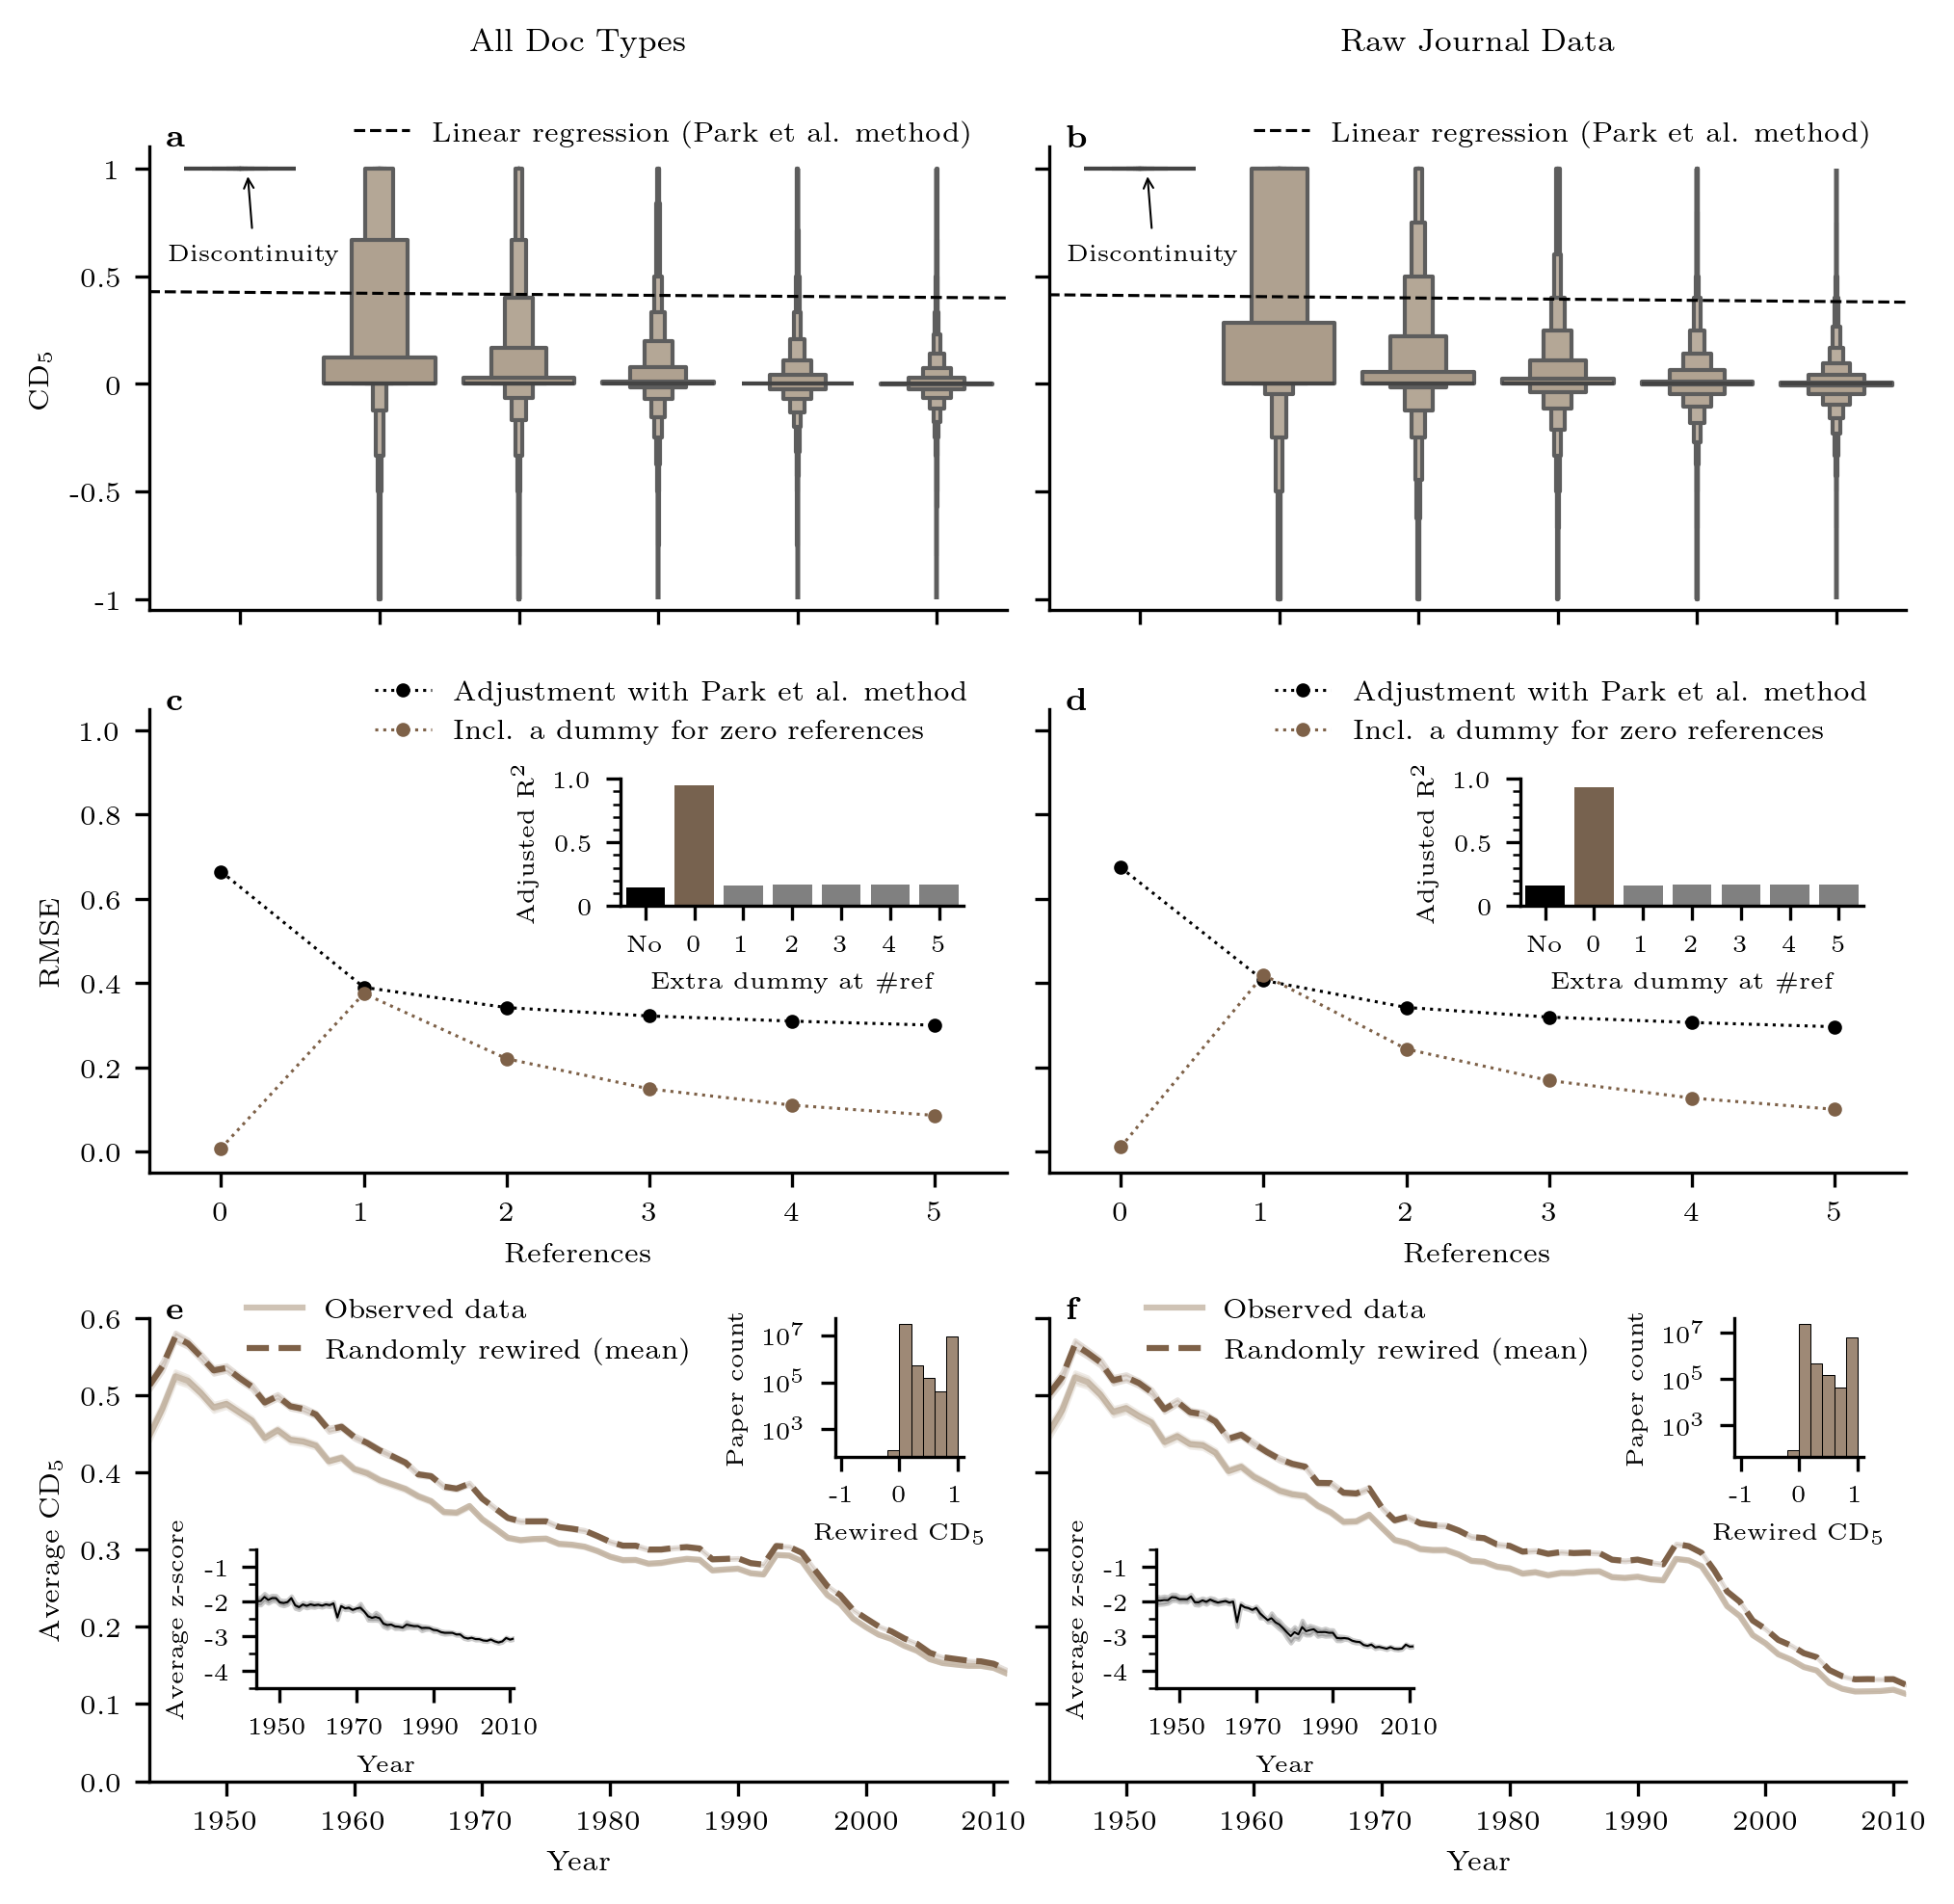

In [ ]:
### WARNING: This cell can take some time to run ~30 min ###

CONFIDENCE_INTERVAL = 95 

### RECOMMENDATION: For faster runtime, set CONFIDENCE_INTERVAL to None ### 

Figure2, ax2 = plt.subplot_mosaic([['1', '1', '.', '2','2'],
                                   ['A','A', '.', 'B', 'B'],
                                   ['.','.','.','.','.'],
                                   ['C','C','.','D', 'D'],
                                    ['.','.','.','.','.'],
                                   ['E', 'E','.', 'F', 'F']],
                                  figsize=(7.08,6.69),
                                  gridspec_kw = {'width_ratios':[1, 1, 0.1, 1, 1],
                                                 'height_ratios': [0.1, 1, 0.1, 1, 0.2, 1]},
                                                 dpi = 300
                                                 )


plt.rcParams['legend.title_fontsize'] = 7

#---------------------------------------------1---------------------------------------------
ax2['1'].set_axis_off()
ax2['1'].set_title('All Doc Types', fontsize = 8)

#---------------------------------------------2---------------------------------------------
ax2['2'].set_axis_off()
ax2['2'].set_title('Raw Journal Data', fontsize = 8)

#====================== Discontinuity at zero references =================================== 

"""
a: Distribution of CD index against number of references for papers (all doc types) 
"""

#Add the regression line y=0.4250995-0.0047266*x=alpha+beta_1*x (see model 1 in Supplementary Table S1)

regplot2=sns.lineplot(x=np.arange(-1, 6, 0.1),
              y=0.4250995-0.0047266*np.arange(-1, 6, 0.1),
              linestyle="--",
              linewidth=0.75,
              color="black",
              ax=ax2["A"]
              )

boxenplot2=sns.boxenplot(
    data=SciSciNet_df[SciSciNet_df["references"] <= 5],
    x="references",
    y="cd_5",
    color="#B09C8599",
    linewidth=1,
    showfliers=True,
    ax=ax2["A"]
)

ax2["A"].set(xlim=(-0.65, 5.5))
ax2["A"].set(ylim=(-1.05, 1.1))
ax2["A"].set_xlabel("", fontsize = 7)
ax2["A"].set_xticks(ticks=[0,1,2,3,4,5], labels=["","","","","",""], fontsize=7)
ax2["A"].set_ylabel(r"$\mathrm{CD}_5$", fontsize = 7)
ax2["A"].set_yticks(ticks=[-1,-0.5,0,0.5,1], labels=["-1","-0.5","0","0.5","1"], fontsize=7)

ax2["A"].text(0.02,1,r'$\textbf{a}$', transform=ax2["A"].transAxes,fontsize = 8)

ax2["A"].annotate('Discontinuity', xy=(0.05, 1), xytext=(0.1, 0.55),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=0.5),
             horizontalalignment='center', verticalalignment='bottom', fontsize=6)

# legend
ax2["A"].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='--', linewidth=0.75,
               markersize=1,
               label='Linear regression (Park et al. method)'
               )
    ],
    loc=(0.225, 0.975),
    frameon=False,
    fontsize=7,
)

sns.despine(ax=ax2["A"],left=False, bottom=False)

del boxenplot2, regplot2
gc.collect()


"""
b: Distribution of CD index against number of references for papers (raw journal data) 
"""

#Add the regression line y=0.41013936361603415-0.005594545887221938*x=alpha+beta_1*x (see 26_regression_SciSciNet_journal.ipynb)

regplot2=sns.lineplot(x=np.arange(-1, 6, 0.1),
              y=0.41013936361603415-0.005594545887221938*np.arange(-1, 6, 0.1),
              linestyle="--",
              linewidth=0.75,
              color="black",
              ax=ax2["B"]
              )

boxenplot2=sns.boxenplot(
    data=SciSciNet_df[(SciSciNet_df["references_raw"] <= 5) & mask_raw_journal_data],
    x="references_raw",
    y="cd_5_raw",
    color="#B09C8599",
    linewidth=1,
    showfliers=True,
    ax=ax2["B"]
)

ax2["B"].set(xlim=(-0.65, 5.5))
ax2["B"].set(ylim=(-1.05, 1.1))
ax2["B"].set_xlabel("", fontsize = 7)
ax2["B"].set_xticks(ticks=[0,1,2,3,4,5], labels=["","","","","",""], fontsize=7)
ax2["B"].set_ylabel(r"", fontsize = 7)
ax2["B"].set_yticks(ticks=[-1,-0.5,0,0.5,1], labels=["","","","",""], fontsize=7)

ax2["B"].text(0.02,1,r'$\textbf{b}$', transform=ax2["B"].transAxes,fontsize = 8)

ax2["B"].annotate('Discontinuity', xy=(0.05, 1), xytext=(0.1, 0.55),
             arrowprops=dict(facecolor='black', arrowstyle='->', linewidth=0.5),
             horizontalalignment='center', verticalalignment='bottom', fontsize=6)

# legend
ax2["B"].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='--', linewidth=0.75,
               markersize=1,
               label='Linear regression (Park et al. method)'
               )
    ],
    loc=(0.225, 0.975),
    frameon=False,
    fontsize=7,
)

sns.despine(ax=ax2["B"],left=False, bottom=False)

del boxenplot2, regplot2
gc.collect()

#================================= Regression =================================== 

"""
c: Regression adjustment plot for papers (all doc types)
"""

#Calculate mean residuals_squared_1 per number of references
mask=SciSciNet_df["references"] <= 5
rmse_1_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_1'].mean().values)
rmse_1=ax2['C'].errorbar(
                x=np.arange(0, 6, 1),
                y=rmse_1_mean,
                color="black",
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )


#Calculate mean residuals_squared_2 per cited_total
mask=SciSciNet_df["references"] <= 5
rmse_2_mean=np.sqrt(SciSciNet_df[mask].groupby('references')['residuals_squared_2'].mean().values)
rmse_2=ax2['C'].errorbar(x=np.arange(0, 6, 1),
                y=rmse_2_mean,
                color='#7E6148FF',
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )

ax2['C'].set_xlabel("References", fontsize=7)
ax2['C'].set(xlim=(-0.5, 5.5))
ax2['C'].set_ylim(-0.05, 1.05)
ax2['C'].set_ylabel('RMSE', fontsize = 7)
ax2['C'].set_xticks(ticks=[0,1,2,3,4,5], labels=[r"0","1","2","3","4","5"], fontsize=7)
yticks=np.arange(0, 1.1, 0.2) 
ax2['C'].set_yticks(ticks=yticks, labels=[str(x)[0:3] for x in yticks], fontsize=7)
ax2['C'].set_title("")
ax2['C'].text(0.02,1,r'$\textbf{c}$', transform=ax2['C'].transAxes,fontsize = 8)

sns.despine(ax=ax2['C'],left=False, bottom=False)

# legend
ax2['C'].legend(
    handles=[
        Line2D([0], [0], color='black', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Incl. a dummy for zero references'),
    ],
    loc=(0.25,0.9),
    frameon=False,
    fontsize=7,
)

del rmse_1, rmse_2
gc.collect()

ax2['C_inset'] = ax2['C'].inset_axes([0.55, 0.575, 0.4, 0.275])

#HUE FOR COLORING THE BARS
HUE=[0, 1, 2, 2, 2, 2, 2]

#Plot the R2_reference_dummy_papers as a line
paper_dummies=sns.barplot(x=np.arange(0, 7, 1),
                            y=R2_reference_dummy_papers,
                            hue=HUE,
                            dodge=False,
                            palette=['black', '#7E6148FF', 'grey'],
                            ax=ax2['C_inset']
                            )

ax2['C_inset'].set_xlabel(r"Extra dummy at $\# \mathrm{ref}$", fontsize=6)
ax2['C_inset'].set_ylabel(r"Adjusted $\mathrm{R}^2$", fontsize = 6)
ax2['C_inset'].set_xticks(ticks=[0,1,2,3,4,5, 6], labels=[r"No","0","1","2","3","4", "5"], fontsize=6)
yticks=np.arange(0, 1.1, 0.5)
ax2['C_inset'].set_yticks(yticks, labels=['0', '0.5', '1.0'], fontsize=6, minor=False)
ax2['C_inset'].set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9],labels=['', '', '', '', '', '', '', ''], minor=True)

#Remove legend of inset 
ax2['C_inset'].get_legend().remove()
sns.despine(ax=ax2['C_inset'],left=False, bottom=False) 

del paper_dummies
gc.collect()

"""
d: Regression adjustment plot for papers (raw journal data)
"""

#Calculate mean residuals_squared_1 per number of references
mask=SciSciNet_df["references_raw"] <= 5
rmse_1_mean=np.sqrt(SciSciNet_df[mask & mask_raw_journal_data].groupby('references_raw')['residuals_squared_1_raw_journal_data'].mean().values)
rmse_1=ax2['D'].errorbar(
                x=np.arange(0, 6, 1),
                y=rmse_1_mean,
                color="black",
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )


#Calculate mean residuals_squared_2 per cited_total
mask=SciSciNet_df["references_raw"] <= 5
rmse_2_mean=np.sqrt(SciSciNet_df[mask & mask_raw_journal_data].groupby('references_raw')['residuals_squared_2_raw_journal_data'].mean().values)
rmse_2=ax2['D'].errorbar(x=np.arange(0, 6, 1),
                y=rmse_2_mean,
                color='#7E6148FF',
                linestyle=':',
                linewidth=0.75,
                marker='.',
                markersize=5
                )

ax2['D'].set_xlabel("References", fontsize=7)
ax2['D'].set(xlim=(-0.5, 5.5))
ax2['D'].set_ylim(-0.05, 1.05)
ax2['D'].set_ylabel('', fontsize = 7)
ax2['D'].set_xticks(ticks=[0,1,2,3,4,5], labels=[r"0","1","2","3","4","5"], fontsize=7)
yticks=np.arange(0, 1.1, 0.2) 
ax2['D'].set_yticks(ticks=yticks, labels=['' for x in yticks], fontsize=7)
ax2['D'].text(0.02,1,r'$\textbf{d}$', transform=ax2['D'].transAxes,fontsize = 8)

sns.despine(ax=ax2['D'],left=False, bottom=False)

# legend
ax2['D'].legend(
    handles=[
        Line2D([0], [0], color='black', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', marker='.', markersize=5, linestyle=':', linewidth=0.75,
               label=r'Incl. a dummy for zero references'),
    ],
    loc=(0.25,0.9),
    frameon=False,
    fontsize=7,
)

del rmse_1, rmse_2
gc.collect()

ax2['D_inset'] = ax2['D'].inset_axes([0.55, 0.575, 0.4, 0.275])

#HUE FOR COLORING THE BARS
HUE=[0, 1, 2, 2, 2, 2, 2]

#Plot the R2_reference_dummy_papers as a line
paper_dummies=sns.barplot(x=np.arange(0, 7, 1),
                            y=R2_reference_dummy_papers_raw_journal_data,
                            hue=HUE,
                            dodge=False,
                            palette=['black', '#7E6148FF', 'grey'],
                            ax=ax2['D_inset']
                            )

ax2['D_inset'].set_xlabel(r"Extra dummy at $\# \mathrm{ref}$", fontsize=6)
ax2['D_inset'].set_ylabel(r"Adjusted $\mathrm{R}^2$", fontsize = 6)
ax2['D_inset'].set_xticks(ticks=[0,1,2,3,4,5, 6], labels=[r"No","0","1","2","3","4", "5"], fontsize=6)
yticks=np.arange(0, 1.1, 0.5)
ax2['D_inset'].set_yticks(yticks, labels=['0', '0.5', '1.0'], fontsize=6, minor=False)
ax2['D_inset'].set_yticks([0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9],labels=['', '', '', '', '', '', '', ''], minor=True)

#Remove legend of inset 
ax2['D_inset'].get_legend().remove()
sns.despine(ax=ax2['D_inset'],left=False, bottom=False) 

del paper_dummies
gc.collect()

#=========================================== Simulation =========================================================

"""
e: CD_5 evolution over time for rewired paper network (all doc types)
"""

original_evolution=sns.lineplot(data=SciSciNet_rewired_df,
             x="year",
             y="cd_5_o",
             color = "#B09C8599",
             ci=CONFIDENCE_INTERVAL, 
             ax = ax2['E'])
    
rewired_evolution=sns.lineplot(data=SciSciNet_rewired_df,
                 x="year",
                 y=f"cd_5_rmean",
                 color = '#7E6148FF',
                 linestyle = '--',
                 ci=CONFIDENCE_INTERVAL,
                 ax = ax2['E'])

ax2['E'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks = config.PAPER_YEAR_TICKS
ax2['E'].set_xticks(xticks,[str(x) for x in xticks])
ax2['E'].set_xlabel("Year",fontsize = 7)
ax2['E'].set_ylabel(r"Average $\mathrm{CD}_5$",fontsize = 7)
ax2['E'].set_ylim(0, 0.6)
yticks=np.arange(0, 0.7, 0.1)
ax2['E'].set_yticks(yticks, [str(y)[0:3] for y in yticks], fontsize=7)
ax2['E'].text(0.02,1,r'$\textbf{e}$', transform=ax2['E'].transAxes,fontsize = 8)

ax2['E'].tick_params(axis='x', labelsize=7)
ax2['E'].tick_params(axis='y', labelsize=7)
sns.despine(ax=ax2['E'],left=False, bottom=False)

#Add an inset plot to ax2['E'] to show the distribution of the rewired CD_5
ax2['E_inset'] = ax2['E'].inset_axes([0.8, 0.7, 0.15, 0.3])

Histogram=sns.histplot(x=f"cd_5_rmean",
                 data=SciSciNet_rewired_df,
                 bins=10,
                 binrange=(-1,1), 
                 stat="count",
                 color = '#7E6148FF',
                 ax=ax2['E_inset'])

ax2['E_inset'].set_yscale("log")
ax2['E_inset'].set_xticks([-1, 0, 1],['-1', '0', '1'], fontsize=6)
ax2['E_inset'].set_xlabel(r'Rewired $\mathrm{CD}_5$', fontsize = 6)
ax2['E_inset'].set_ylabel("Paper count",fontsize = 6)
ax2['E_inset'].set_yticks(ticks=[1e3,1e5,1e7], fontsize=6)

ax2['E_inset'].tick_params(axis='x', labelsize=6)
ax2['E_inset'].tick_params(axis='y', labelsize=6)
sns.despine(ax=ax2['E_inset'],left=False, bottom=False)

del Histogram
gc.collect()

#Add an inset plot to ax2['E'] to show the average z-score over time 
ax2['E_inset2'] = ax2['E'].inset_axes([0.125, 0.2, 0.3, 0.3])

#Remove large z scores (mostly due) to floating point issues in calculation of the standard deviation 
mask=abs(SciSciNet_rewired_df['cd_5_zscore'])<=10000

inset_z_score=sns.lineplot(data=SciSciNet_rewired_df[mask],
                x="year",
                y="cd_5_zscore",
                color = 'black',
                linewidth = 0.5,
                ci=CONFIDENCE_INTERVAL, 
                ax = ax2['E_inset2'])

ax2['E_inset2'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks=[1950, 1970, 1990, 2010]
ax2['E_inset2'].set_xticks(xticks,[str(x) for x in xticks], fontsize=6)
ax2['E_inset2'].set_xlabel("Year",fontsize = 6)
ax2['E_inset2'].set_ylabel(r"Average z-score",fontsize = 6)
ax2['E_inset2'].set_ylim(-4.5, -0.5)
ax2['E_inset2'].set_yticks(ticks=[-4, -3, -2, -1], labels=["-4", "-3","-2","-1"], fontsize=6)
ax2['E_inset2'].set_yticks([-4.5, -3.5, -2.5, -1.5, -0.5],labels=['', '', '', '',''], minor=True)


sns.despine(ax=ax2['E_inset2'],left=False, bottom=False)

del inset_z_score   
gc.collect()

#Add legend
legpapers = ax2['E'].legend(labels=['original' ,'','rewired','', 
                                    ],
                                 loc = (0.45,0.6),
                                 fontsize = 7,
                                 frameon=False)
h = legpapers.get_lines()
legpapers_b = ax2['E'].legend(handles = [h[0],h[1]],
                              labels=['Observed data' ,'Randomly rewired (mean)'],
                              loc = (0.1, 0.875),
                              framealpha=0.0,
                              fontsize = 7)
legpapers_b.get_frame().set_linewidth(0.0)

del original_evolution, rewired_evolution
gc.collect()


"""
F: CD_5 evolution over time for rewired paper network (raw journal data)
"""

original_evolution=sns.lineplot(data=SciSciNet_rewired_df_raw,
             x="year",
             y="cd_5_o",
             color = "#B09C8599",
             ci=CONFIDENCE_INTERVAL, 
             ax = ax2['F'])
    
rewired_evolution=sns.lineplot(data=SciSciNet_rewired_df_raw,
                 x="year",
                 y=f"cd_5_rmean",
                 color = '#7E6148FF',
                 linestyle = '--',
                 ci=CONFIDENCE_INTERVAL,
                 ax = ax2['F'])

ax2['F'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks = config.PAPER_YEAR_TICKS
ax2['F'].set_xticks(xticks,[str(x) for x in xticks])
ax2['F'].set_xlabel("Year",fontsize = 7)
ax2['F'].set_ylabel("",fontsize = 7)
ax2['F'].set_ylim(0, 0.6)
yticks=np.arange(0, 0.7, 0.1)
ax2['F'].set_yticks(yticks, ['' for y in yticks], fontsize=7)
ax2['F'].text(0.02,1,r'$\textbf{f}$', transform=ax2['F'].transAxes,fontsize = 8)

ax2['F'].tick_params(axis='x', labelsize=7)
ax2['F'].tick_params(axis='y', labelsize=7)
sns.despine(ax=ax2['F'],left=False, bottom=False)

#Add an inset plot to ax2['F'] to show the distribution of the rewired CD_5
ax2['F_inset'] = ax2['F'].inset_axes([0.8, 0.7, 0.15, 0.3])

Histogram=sns.histplot(x=f"cd_5_rmean",
                 data=SciSciNet_rewired_df_raw,
                 bins=10,
                 binrange=(-1,1), 
                 stat="count",
                 color = '#7E6148FF',
                 ax=ax2['F_inset'])

ax2['F_inset'].set_yscale("log")
ax2['F_inset'].set_xticks([-1, 0, 1],['-1', '0', '1'], fontsize=6)
ax2['F_inset'].set_xlabel(r'Rewired $\mathrm{CD}_5$', fontsize = 6)
ax2['F_inset'].set_ylabel("Paper count",fontsize = 6)
ax2['F_inset'].set_yticks(ticks=[1e3,1e5,1e7], fontsize=6)

ax2['F_inset'].tick_params(axis='x', labelsize=6)
ax2['F_inset'].tick_params(axis='y', labelsize=6)
sns.despine(ax=ax2['F_inset'],left=False, bottom=False)

del Histogram
gc.collect()

#Add an inset plot to ax2['F'] to show the average z-score over time 
ax2['F_inset2'] = ax2['F'].inset_axes([0.125, 0.2, 0.3, 0.3])

#Remove large z scores (mostly due) to floating point issues in calculation of the standard deviation 
mask=abs(SciSciNet_rewired_df_raw['cd_5_zscore'])<=10000

inset_z_score=sns.lineplot(data=SciSciNet_rewired_df_raw[mask],
                x="year",
                y="cd_5_zscore",
                color = 'black',
                linewidth = 0.5,
                ci=CONFIDENCE_INTERVAL, 
                ax = ax2['F_inset2'])

ax2['F_inset2'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks=[1950, 1970, 1990, 2010]
ax2['F_inset2'].set_xticks(xticks,[str(x) for x in xticks], fontsize=6)
ax2['F_inset2'].set_xlabel("Year",fontsize = 6)
ax2['F_inset2'].set_ylabel(r"Average z-score",fontsize = 6)
ax2['F_inset2'].set_ylim(-4.5, -0.5)
ax2['F_inset2'].set_yticks(ticks=[-4, -3, -2, -1], labels=["-4", "-3","-2","-1"], fontsize=6)
ax2['F_inset2'].set_yticks([-4.5, -3.5, -2.5, -1.5, -0.5],labels=['', '', '', '',''], minor=True)


sns.despine(ax=ax2['F_inset2'],left=False, bottom=False)

del inset_z_score   
gc.collect()

#Add legend
legpapers = ax2['F'].legend(labels=['original' ,'','rewired','', 
                                    ],
                                 loc = (0.45,0.6),
                                 fontsize = 7,
                                 frameon=False)
h = legpapers.get_lines()
legpapers_b = ax2['F'].legend(handles = [h[0],h[1]],
                              labels=['Observed data' ,'Randomly rewired (mean)'],
                              loc = (0.1, 0.875),
                              framealpha=0.0,
                              fontsize = 7)
legpapers_b.get_frame().set_linewidth(0.0)

del original_evolution, rewired_evolution
gc.collect()

Figure2.tight_layout()
Figure2.subplots_adjust(hspace = 0.1,wspace = 0)
Figure2.savefig(config.OUTPUT_PATH+'RebuttalFigure2_raw_journal_data.pdf')

# Supplementary Figure S12

For the raw SciSciNet journal data, the hidden outliers are driving the decline in disruptiveness, and papers with $\mathrm{CD}_5=1$ predominantly make zero references.

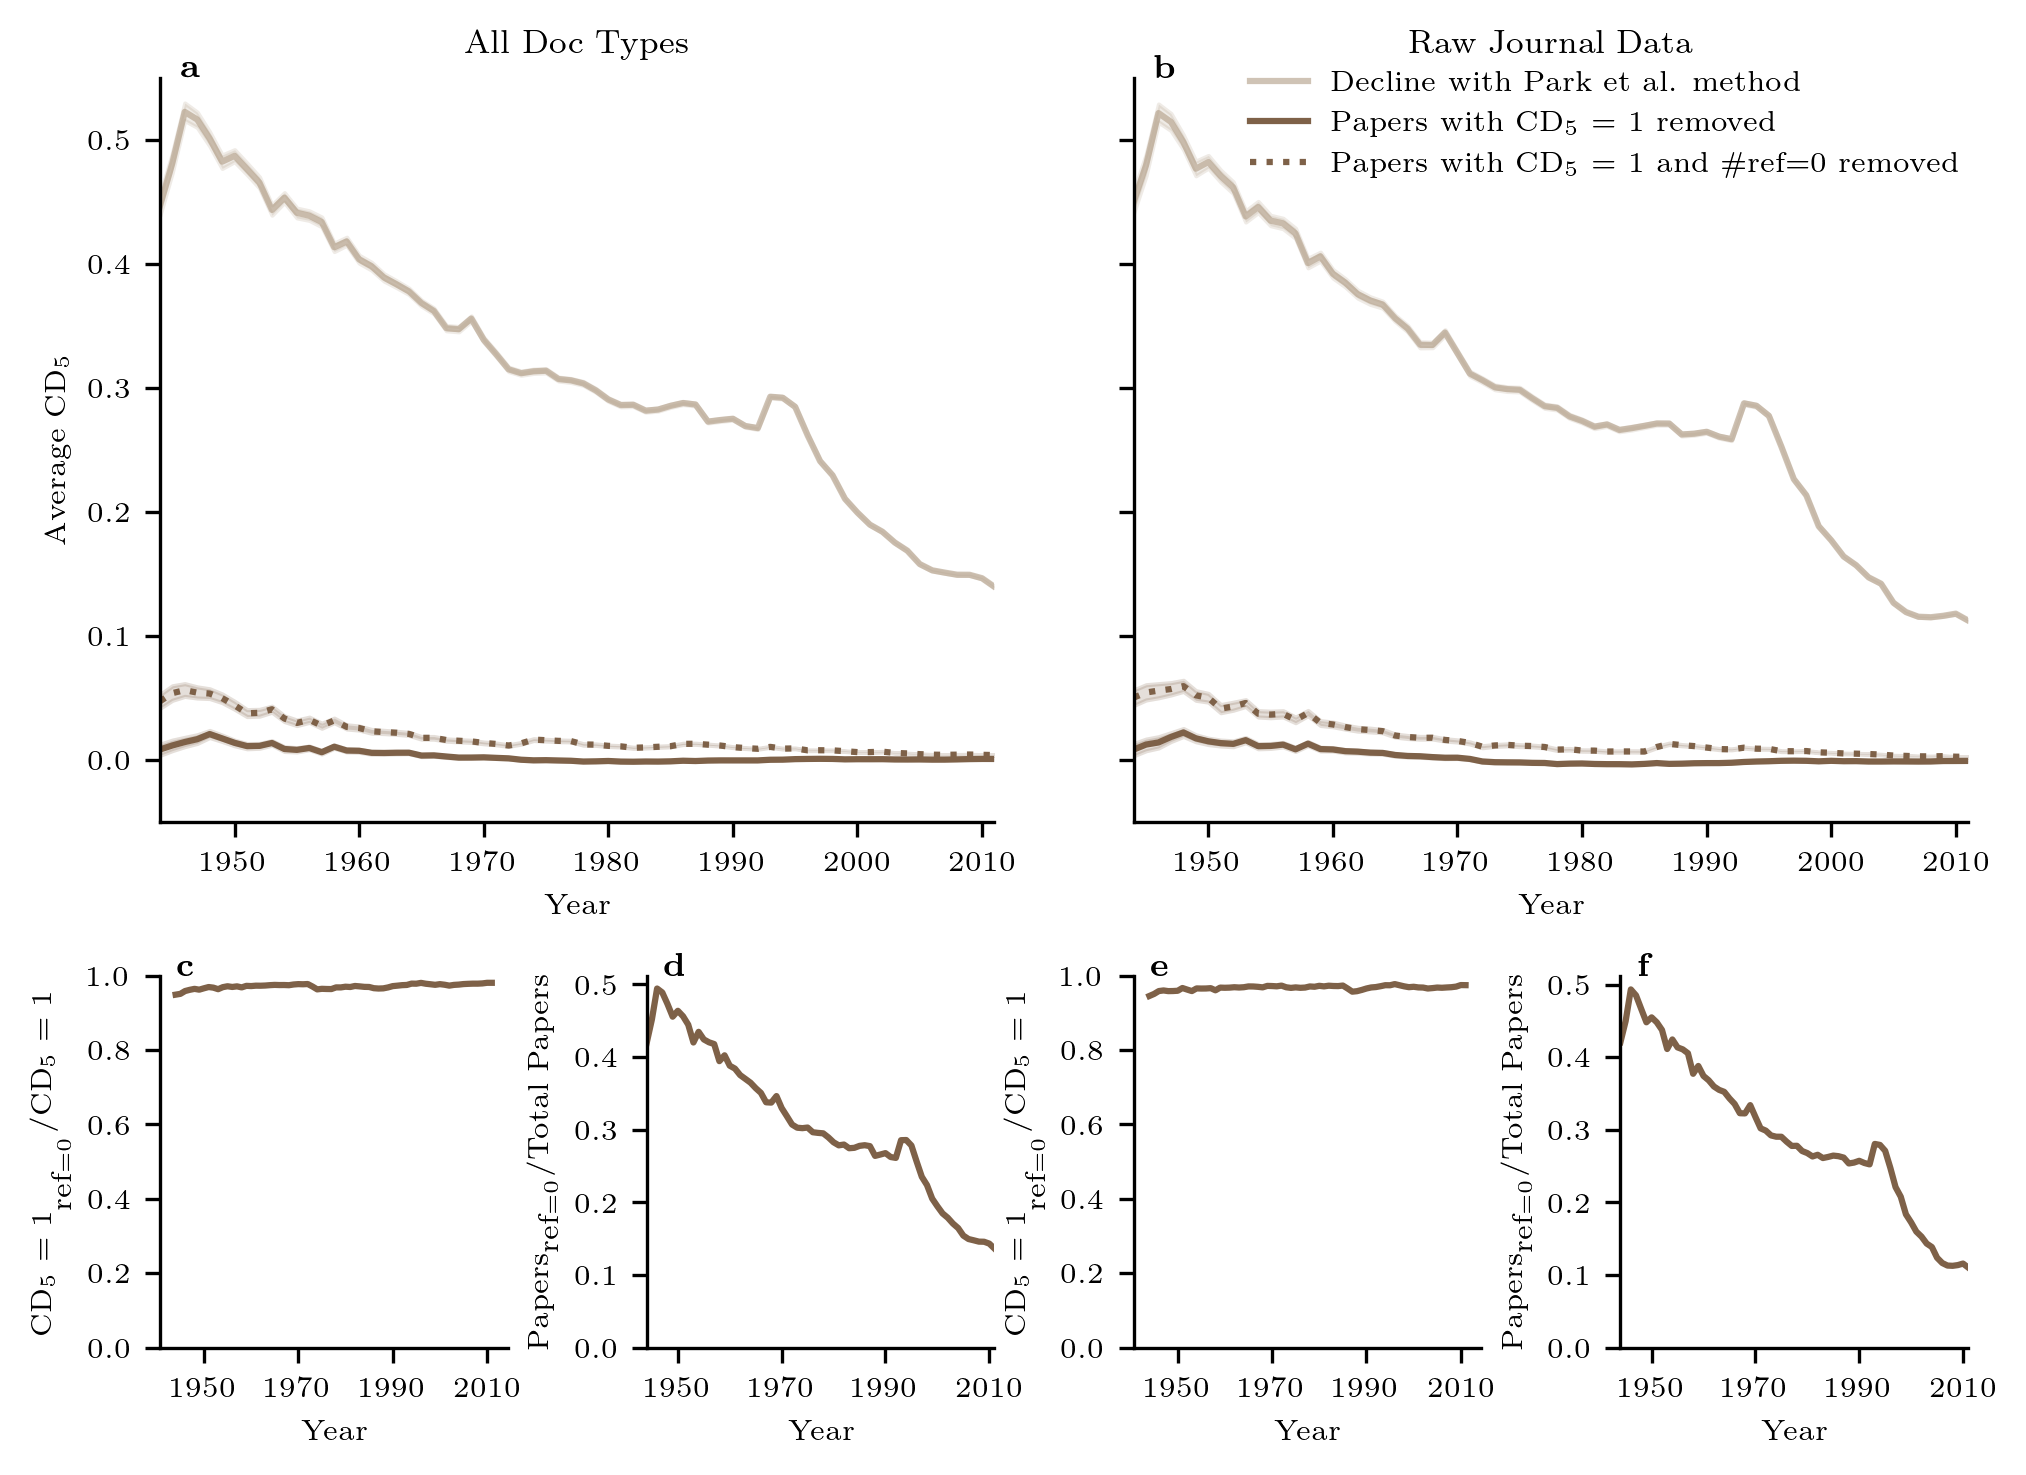

In [21]:
Figure, ax = plt.subplot_mosaic([
                                ['A', 'A', 'A', '.', 'B','B', 'B'],
                                ['.', '.', '.', '.', '.', '.', '.'],
                                ['C', '.', 'D', '.', 'E','.', 'F']
                                ],
                                figsize=(7.08,6.69*3/4),
                                gridspec_kw = {'width_ratios':[1, 0.4, 1, 0.4, 1, 0.4, 1],
                                                 'height_ratios': [2,0.2, 1]},
                                dpi = 300
                                )


plt.rcParams['legend.title_fontsize'] = 7

CONFIDENCE_INTERVAL=95 

ax['A'].set_title('All Doc Types', fontsize=8)
ax['B'].set_title('Raw Journal Data', fontsize=8)

"""
Lineplots: CD_5 evolution over time for all DocTypes
"""

sciscinetfull = sns.lineplot(data=SciSciNet_df,
             x="Year",
             y="cd_5",
             color = '#B09C8599',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['A'])

ax['A'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks = config.PAPER_YEAR_TICKS
ax['A'].set_xticks(xticks,[str(x) for x in xticks])
ax['A'].set_xlabel("Year",fontsize = 7)
ax['A'].set_ylabel(r"Average $\mathrm{CD}_{5}$",fontsize = 7)
ax['A'].set_ylim(-0.05, 0.55)
ax['A'].tick_params(axis='x', labelsize=7)
ax['A'].tick_params(axis='y', labelsize=7)
ax['A'].text(0.025,1.0,r'$\textbf{a}$', transform=ax['A'].transAxes,fontsize = 8)
sns.despine(ax=ax['A'], left=False, bottom=False)

mask=SciSciNet_df.cd_5==1
sciscinet_p1 = sns.lineplot(data=SciSciNet_df[~mask],
             x="Year",
             y="cd_5",
             color = '#7E6148FF',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['A'])

mask=SciSciNet_df.references==0
sciscinet_ref = sns.lineplot(data=SciSciNet_df[~mask],
             x="Year",
             y="cd_5",
             color = '#7E6148FF',
             linestyle = ':',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['A'])

del sciscinetfull
del sciscinet_p1
del sciscinet_ref
gc.collect()

"""
Lineplots: CD_5 evolution over time for the raw journal data (excl. fields of Humanities)
"""

sciscinetfull = sns.lineplot(data=SciSciNet_df[mask_raw_journal_data],
             x="Year",
             y="cd_5_raw",
             color = '#B09C8599',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['B'])

mask=SciSciNet_df.cd_5_raw==1
sciscinet_p1 = sns.lineplot(data=SciSciNet_df[~mask & mask_raw_journal_data],
             x="Year",
             y="cd_5_raw",
             color = '#7E6148FF',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['B'])

mask=SciSciNet_df.references_raw==0
sciscinet_ref = sns.lineplot(data=SciSciNet_df[~mask & mask_raw_journal_data],
             x="Year",
             y="cd_5_raw",
             color = '#7E6148FF',
             linestyle = ':',
             ci=CONFIDENCE_INTERVAL,
             ax = ax['B'])

ax['B'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
xticks = config.PAPER_YEAR_TICKS
ax['B'].set_xticks(xticks,[str(x) for x in xticks])
ax['B'].set_xlabel("Year",fontsize = 7)
ax['B'].set_ylim(-0.05, 0.55)
ax['B'].set_ylabel("",fontsize = 7)
ax['B'].set_yticklabels([])  
ax['B'].tick_params(axis='x', labelsize=7)
ax['B'].tick_params(axis='y', labelsize=7)
ax['B'].text(0.025,1.0,r'$\textbf{b}$', transform=ax['B'].transAxes,fontsize = 8)
sns.despine(ax=ax['B'], left=False, bottom=False)

legsciscinet = ax['B'].legend(
    labels=['Decline with Park et al. method','',r'Papers with $\mathrm{CD}_5$ = 1 removed', '', r'Papers with $\mathrm{CD}_5$ = 1 and $\#$ref=0 removed'],
    loc = 'best',
    fontsize = 7
    )

h = legsciscinet.get_lines()
legsciscinet_b = ax['B'].legend(handles = [h[0],h[1], h[2]],
                                    labels=['Decline with Park et al. method',r'Papers with $\mathrm{CD}_5$ = 1 removed', r'Papers with $\mathrm{CD}_5$ = 1 and $\#$ref=0 removed'],
                                    #loc = 'best',
                                    loc=(0.125,0.85),
                                    fontsize = 7
                                    )
legsciscinet_b.get_frame().set_linewidth(0.0)

del sciscinetfull
del sciscinet_p1
del sciscinet_ref
gc.collect()

""" Panel C """
#Within the category of papers with CD_5=1, we calculate the relative frequency of papers with no references over time.

papers_per_year_CD5_1_ref_0 =SciSciNet_df[(SciSciNet_df.references==0) & (SciSciNet_df.cd_5==1)].groupby('Year').size().to_numpy()

papers_per_year_CD5_1 =SciSciNet_df[(SciSciNet_df.cd_5==1)].groupby('Year').size().to_numpy()

papers_freq_CD5_1_ref_0 = papers_per_year_CD5_1_ref_0 / papers_per_year_CD5_1 

papers_no_references_df=pd.DataFrame({'Year':np.sort(SciSciNet_df.Year.unique()),
                                    'frequency':papers_freq_CD5_1_ref_0,
                                    'category':'papers with no references'})

lineplotperyearpapers = sns.lineplot(data=papers_no_references_df,
            x="Year",
            y="frequency",
            hue="category",
            palette=['#7E6148FF'],
            ax = ax['C'])
ax['C'].set_xlabel("Year",fontsize = 7)
xticks=[1950, 1970, 1990, 2010]
ax['C'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax['C'].set_ylabel(r'${\textrm{CD}_{5} = 1}_{ _{\textrm{ref} = 0} }/\textrm{CD}_{5} = 1$',fontsize = 7)
ax['C'].set_ylim(0,1)

ax['C'].text(0.05,1,r'$\textbf{c}$', transform=ax['C'].transAxes,fontsize = 8)

ax['C'].tick_params(axis='x', labelsize=7)
ax['C'].tick_params(axis='y', labelsize=7)
sns.despine(ax=ax['C'], left=False, bottom=False)

lineplotperyearpapers.legend_.remove()
del lineplotperyearpapers
gc.collect()

""" Panel D """
#We examine the relative frequency of papers with CD_5=1 and zero references over time. 

#Create a mask to filter for papers with not defined CD index
mask1=SciSciNet_df.cd_5.isna()

#Create a mask to filter for papers with no references
mask2=SciSciNet_df.references==0 
 
#Calculate the number of papers per year and store in a numpy array
papers_per_year=SciSciNet_df[~mask1].groupby('Year').size().to_numpy()
 
#Calculate the number of papers per year with no references and defined CD index, that is CD_5=1
papers_per_year_no_references=SciSciNet_df[~mask1 & mask2].groupby('Year').size().to_numpy()
 
#Calculate the frequency of papers with no references and CD_5=1
frequency_no_references=papers_per_year_no_references/papers_per_year
 
#Create a data_frame with the year and the frequency of papers with no references and CD_5=1
no_references_df=pd.DataFrame({'Year':np.sort(SciSciNet_df[~mask1].Year.unique()),
                                    'frequency':frequency_no_references})
 
lineplotnoreference_paper = sns.lineplot(data=no_references_df,
            x="Year",
            y="frequency",
            color='#7E6148FF',
            ax = ax['D'])

ax['D'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax['D'].set_xlabel("Year",fontsize = 7)
xticks=[1950, 1970, 1990, 2010]
ax['D'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax['D'].set_ylabel(r'$\textrm{Papers}_{\textrm{ref} = 0}/\textrm{Total Papers}$',fontsize = 7)
yticks=np.arange(0,0.6,0.1)
ax['D'].set_yticks(ticks=yticks)
ax['D'].tick_params(axis='x', labelsize=7)
ax['D'].tick_params(axis='y', labelsize=7)
 
ax['D'].text(0.05,1,r'$\textbf{d}$', transform=ax['D'].transAxes,fontsize = 8)
sns.despine(ax=ax['D'], left=False, bottom=False)

del lineplotnoreference_paper
gc.collect()

""" Panel E """
#Within the category of papers with CD_5=1, we calculate the relative frequency of papers with no references over time.

papers_per_year_CD5_1_ref_0 =SciSciNet_df[(SciSciNet_df.references_raw==0) & (SciSciNet_df.cd_5_raw==1) & mask_raw_journal_data].groupby('Year').size().to_numpy()

papers_per_year_CD5_1 =SciSciNet_df[(SciSciNet_df.cd_5_raw==1) & mask_raw_journal_data].groupby('Year').size().to_numpy()

papers_freq_CD5_1_ref_0 = papers_per_year_CD5_1_ref_0 / papers_per_year_CD5_1 

papers_no_references_df=pd.DataFrame({'Year':np.sort(SciSciNet_df[mask_raw_journal_data].Year.unique()),
                                    'frequency':papers_freq_CD5_1_ref_0,
                                    'category':'papers with no references'})

lineplotperyearpapers = sns.lineplot(data=papers_no_references_df,
            x="Year",
            y="frequency",
            hue="category",
            palette=['#7E6148FF'],
            ax = ax['E'])
ax['E'].set_xlabel("Year",fontsize = 7)
xticks=[1950, 1970, 1990, 2010]
ax['E'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax['E'].set_ylabel(r'${\textrm{CD}_{5} = 1}_{ _{\textrm{ref} = 0} }/\textrm{CD}_{5} = 1$',fontsize = 7)
ax['E'].set_ylim(0,1)

ax['E'].text(0.05,1,r'$\textbf{e}$', transform=ax['E'].transAxes,fontsize = 8)

ax['E'].tick_params(axis='x', labelsize=7)
ax['E'].tick_params(axis='y', labelsize=7)
sns.despine(ax=ax['E'], left=False, bottom=False)

lineplotperyearpapers.legend_.remove()
del lineplotperyearpapers
gc.collect()

""" Panel F """
#We examine the relative frequency of papers with CD_5=1 and zero references over time. 

#Create a mask to filter for papers with not defined CD index
mask1=SciSciNet_df.cd_5_raw.isna()

#Create a mask to filter for papers with no references
mask2=SciSciNet_df.references_raw==0 
 
#Calculate the number of papers per year and store in a numpy array
papers_per_year=SciSciNet_df[~mask1 & mask_raw_journal_data].groupby('Year').size().to_numpy()
 
#Calculate the number of papers per year with no references and defined CD index, that is CD_5=1
papers_per_year_no_references=SciSciNet_df[~mask1 & mask2 & mask_raw_journal_data].groupby('Year').size().to_numpy()
 
#Calculate the frequency of papers with no references and CD_5=1
frequency_no_references=papers_per_year_no_references/papers_per_year
 
#Create a data_frame with the year and the frequency of papers with no references and CD_5=1
no_references_df=pd.DataFrame({'Year':np.sort(SciSciNet_df[~mask1 & mask_raw_journal_data].Year.unique()),
                                    'frequency':frequency_no_references})
 
lineplotnoreference_paper = sns.lineplot(data=no_references_df,
            x="Year",
            y="frequency",
            color='#7E6148FF',
            ax = ax['F'])

ax['F'].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax['F'].set_xlabel("Year",fontsize = 7)
xticks=[1950, 1970, 1990, 2010]
ax['F'].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax['F'].set_ylabel(r'$\textrm{Papers}_{\textrm{ref} = 0}/\textrm{Total Papers}$',fontsize = 7)
yticks=np.arange(0,0.6,0.1)
ax['F'].set_yticks(ticks=yticks)
ax['F'].tick_params(axis='x', labelsize=7)
ax['F'].tick_params(axis='y', labelsize=7)
 
ax['F'].text(0.05,1,r'$\textbf{f}$', transform=ax['F'].transAxes,fontsize = 8)
sns.despine(ax=ax['F'], left=False, bottom=False)

del lineplotnoreference_paper
gc.collect()

Figure.tight_layout()
Figure.subplots_adjust(hspace = 0.1,wspace = 0)
Figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_SciSciNet_raw_journal_data_cd_5.pdf')

# Supplementary Figure S13

For the raw SciSciNet journal data, the inclusion of the zero references dummy variable to properly control for the corresponding discontinuity in the $\mathrm{CD}_5$ largely negates the decline of disruptive science.

To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert SciSciNet_margins_raw_journal_data.csv in the data folder.

In [33]:
#Load the margins 
#SciSciNet_margins=pd.read_csv(config.DATA_PATH+'SciSciNet_margins.csv')
SciSciNet_margins_raw_journal_data=pd.read_csv(config.DATA_PATH+'SciSciNet_margins_raw_journal_data.csv')

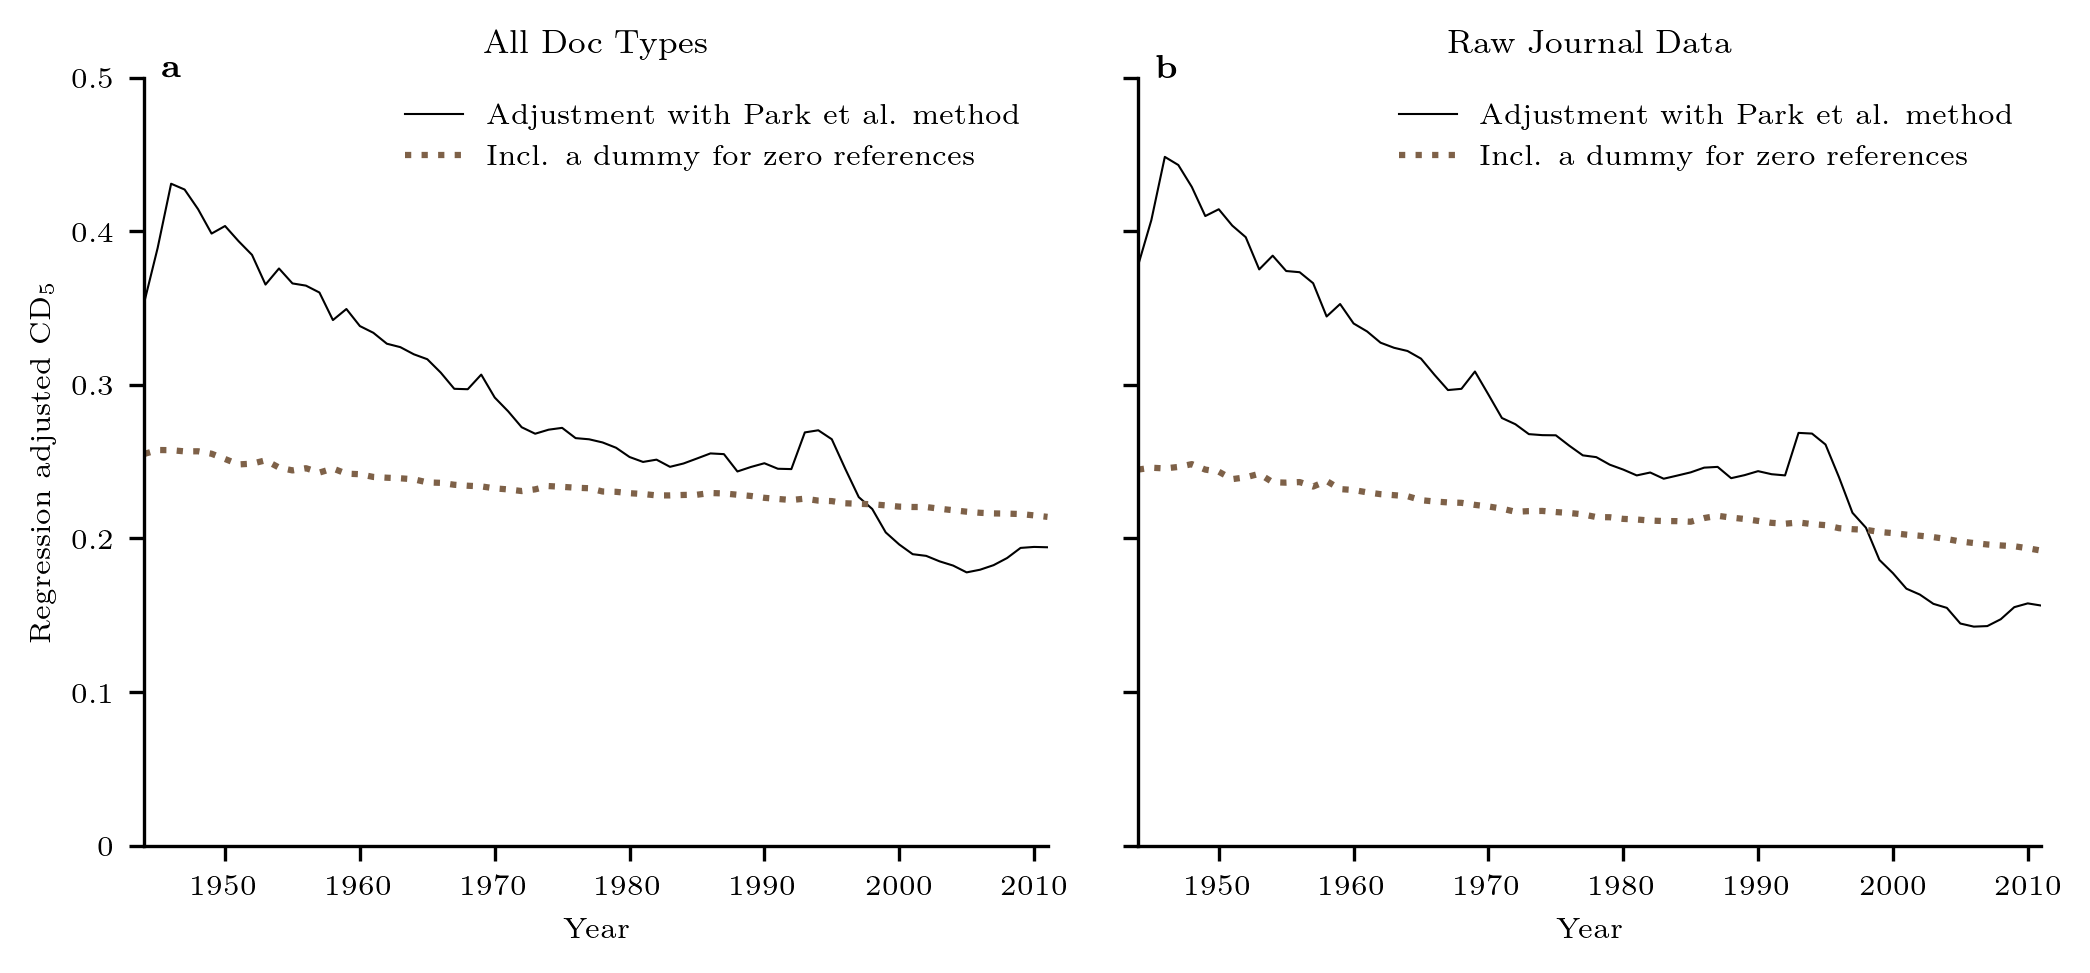

In [ ]:
Figure, ax = plt.subplot_mosaic([['A','.', 'B']],
                                  figsize=(7.08,6.69/2),
                                  gridspec_kw = {'width_ratios':[1, 0.1, 1],
                                                 'height_ratios': [1]},
                                                 dpi = 300
                                                 )


plt.rcParams['legend.title_fontsize'] = 7

ax['A'].set_title('All Doc Types', fontsize=8)
ax['B'].set_title('Raw Journal Data', fontsize=8)

"""
A: Different regression models for adjusted CD_5 for all DocTypes
"""

margins1=sns.lineplot(data=SciSciNet_margins, 
                      x="Years",
                      y="margins_original", 
                      color="black", 
                      linewidth=0.5, 
                      ax=ax["A"]
                      )

margins2=sns.lineplot(data=SciSciNet_margins, 
                      x="Years", 
                      y="margins_zero_refs", 
                      color="#7E6148FF", 
                      linestyle=":",
                      ax=ax["A"]
                      )

ax["A"].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax["A"].set_ylim(0.0, 0.5)
ax["A"].set_xlabel('Year', fontsize=7)
ax["A"].set_ylabel(r"Regression adjusted $\mathrm{CD}_5$", fontsize=7)
xticks=config.PAPER_YEAR_TICKS
ax["A"].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax["A"].set_yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], labels=[r"0","0.1","0.2","0.3","0.4","0.5"], fontsize=7)

ax["A"].text(0.02,1,r'$\textbf{a}$', transform=ax["A"].transAxes,fontsize = 8)

sns.despine(ax=ax["A"],left=False, bottom=False)

del margins1, margins2
gc.collect()

# legend
ax["A"].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', linestyle=':',
               label=r'Incl. a dummy for zero references')],
    loc='upper right',
    frameon=False,
    fontsize=7,
)

"""
B: Different regression models for adjusted CD_5 for Journal and Conference contributions, excl. field of Humanities
"""

margins_original=sns.lineplot(data=SciSciNet_margins_raw_journal_data, x="Years", y="margins_original", color="black", linewidth=0.5, ax=ax["B"])
margins_zero_refs=sns.lineplot(data=SciSciNet_margins_raw_journal_data, x="Years", y="margins_zero_refs", color='#7E6148FF', linestyle=":", ax=ax["B"])

ax["B"].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
ax["B"].set_ylim(0.0, 0.5)
ax["B"].set_xlabel('Year', fontsize=7)
ax["B"].set_ylabel('', fontsize=7)
xticks=config.PAPER_YEAR_TICKS
ax["B"].set_xticks(xticks,[str(x) for x in xticks], fontsize=7)
ax["B"].set_yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], labels=["","","","","",""], fontsize=7)

ax["B"].text(0.02,1,r'$\textbf{b}$', transform=ax["B"].transAxes,fontsize = 8)

sns.despine(ax=ax["B"],left=False, bottom=False)

del margins_original, margins_zero_refs
gc.collect()

#legend
ax["B"].legend(
    handles=[
        Line2D([0], [0], color='black', linestyle='-', linewidth=0.5,
               label=r'Adjustment with Park et al. method'),
        Line2D([0], [0], color='#7E6148FF', linestyle=':',
               label=r'Incl. a dummy for zero references'),
    ],
    loc='upper right',
    frameon=False,
    fontsize=7,
)

Figure.tight_layout()
Figure.subplots_adjust(hspace = 0.1,wspace = 0)
Figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_SciSciNet_regression_margins_raw_journal_data.pdf')

# Supplementary Figure S14

For the raw SciSciNet journal data, the temporal decline of the $\mathrm{CD}_5$ index is mirrored by random citation behaviour supporting that the hidden outliers are driving the decline.

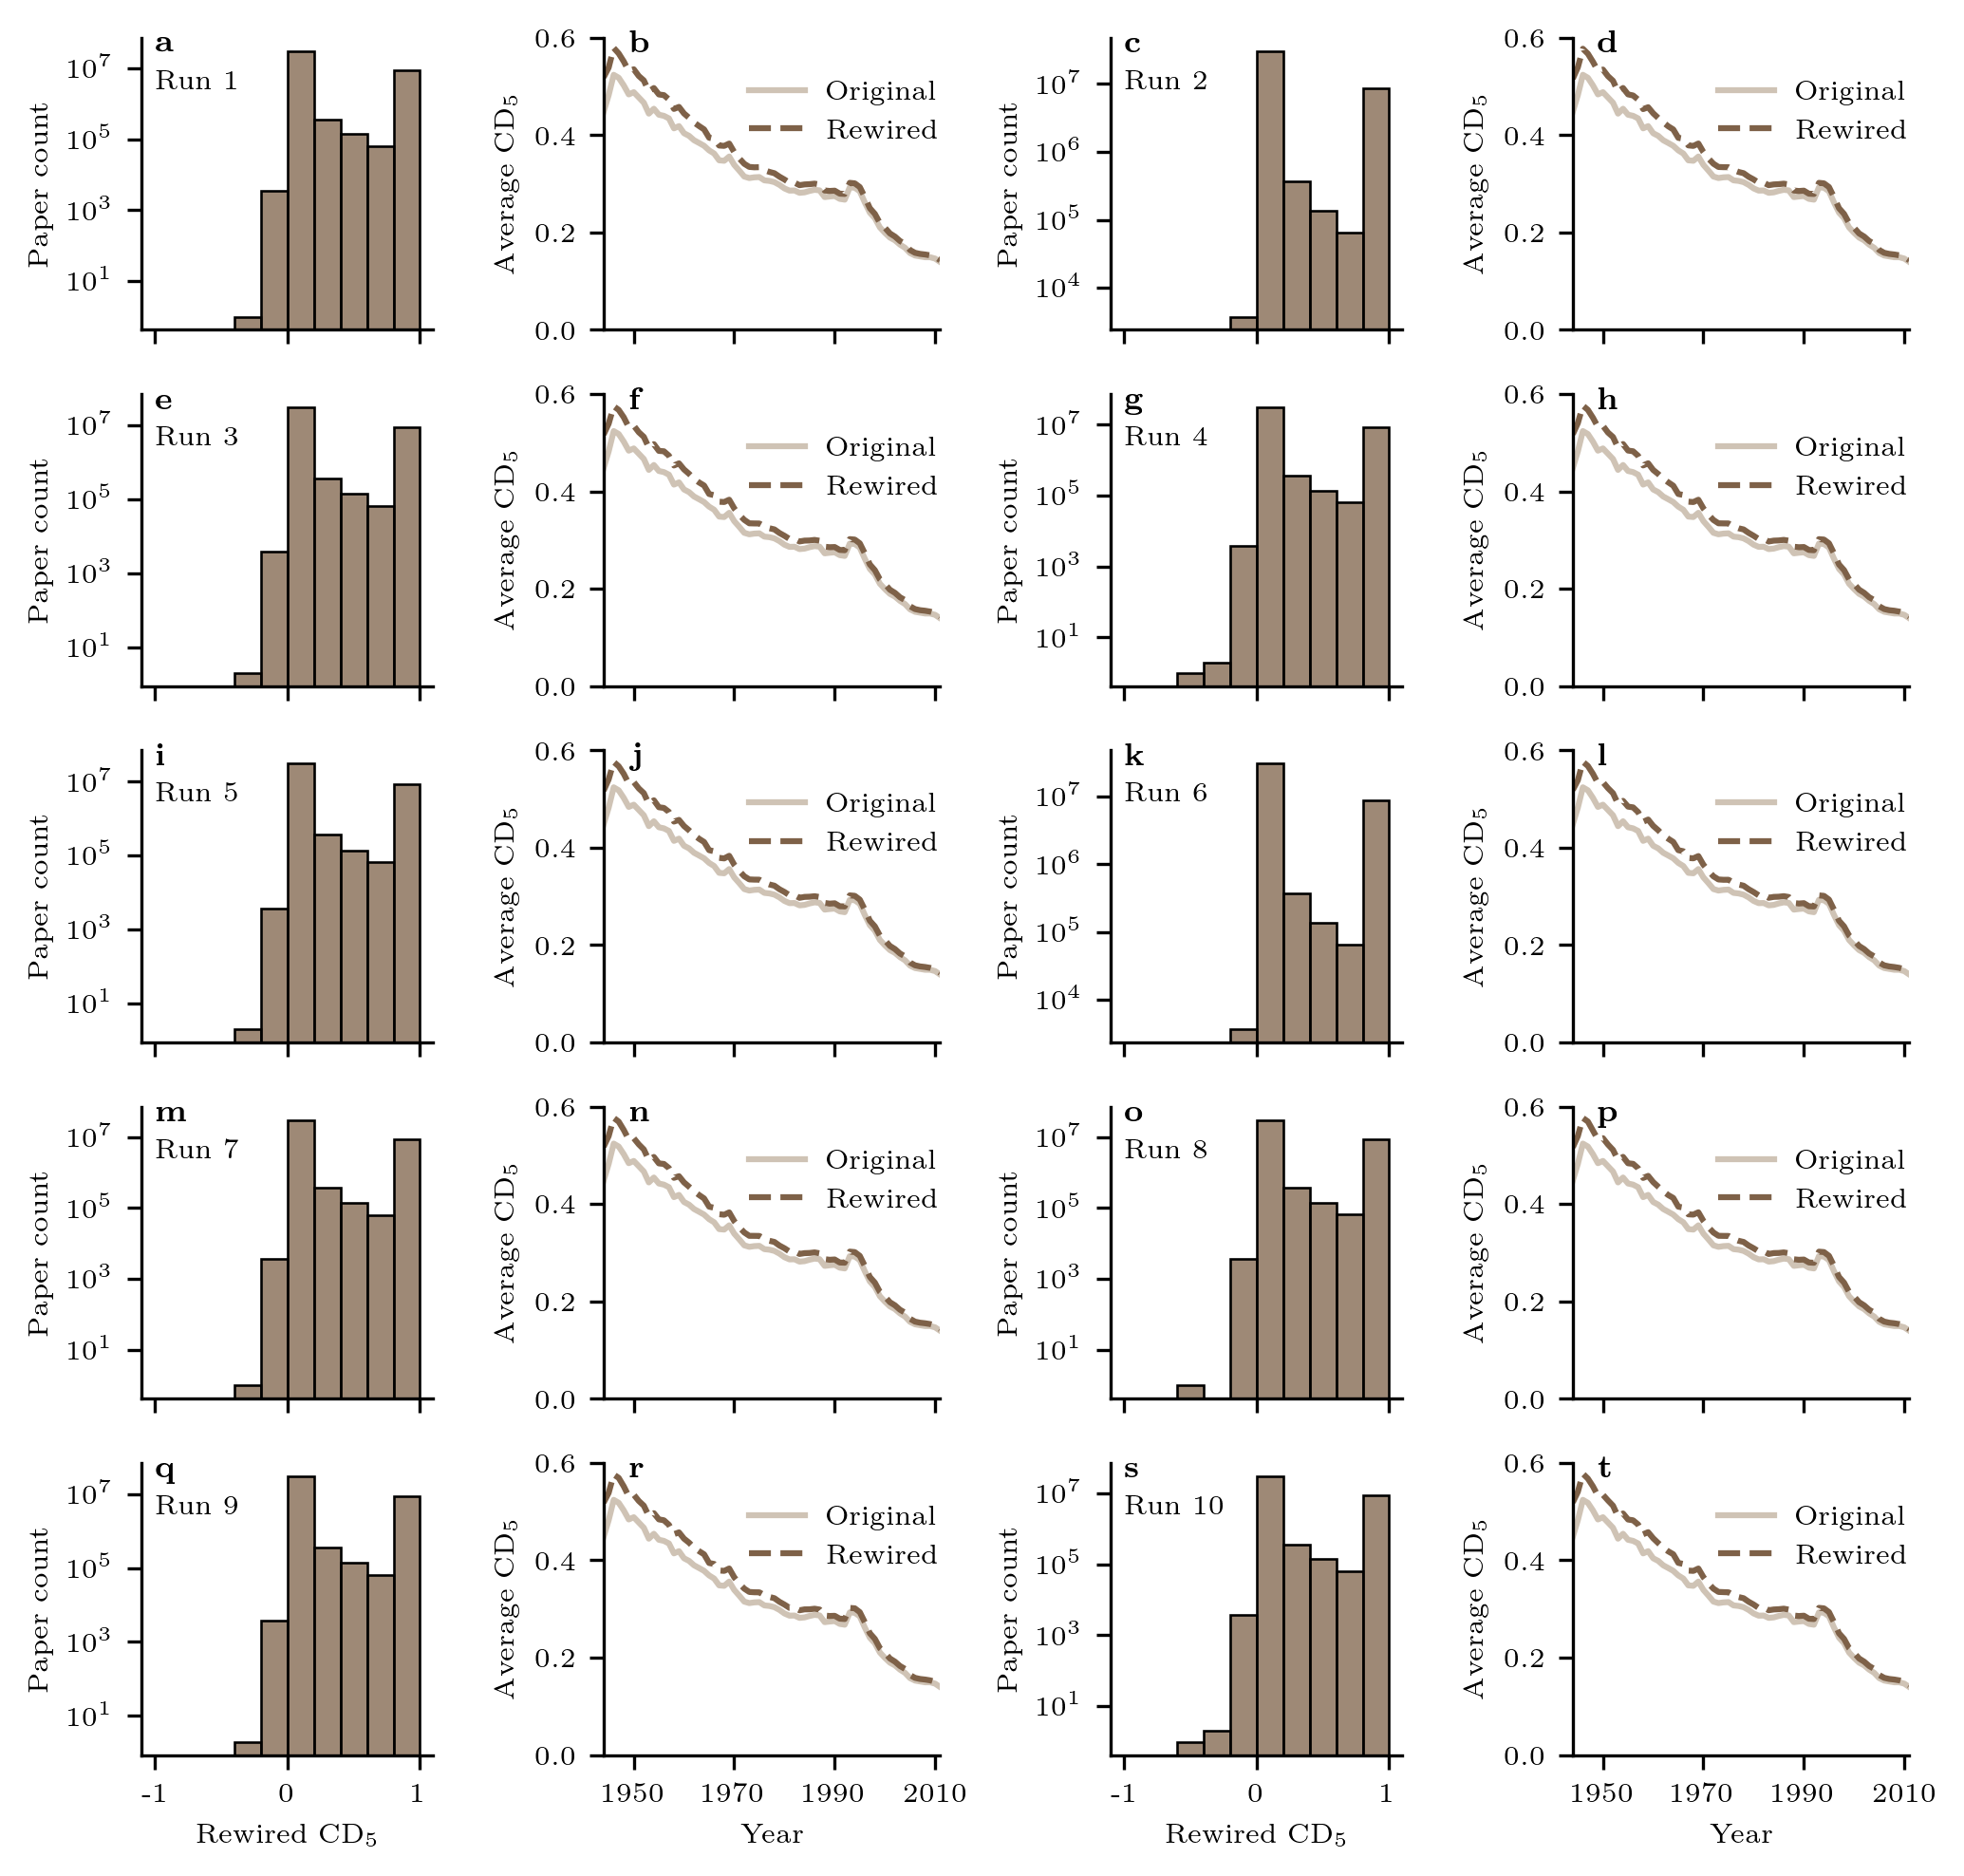

In [ ]:
### Warning: This cell can take some time to run ~180 min ###

CONFIDENCE_INTERVAL=None

### RECOMMENDATION: For faster runtime, set CONFIDENCE_INTERVAL to None ### 

figure, ax = plt.subplot_mosaic([['1', '.','11','.','2','.','12'],
                                 ['.','.','.','.','.','.','.'],
                                ['3','.','13','.','4','.','14'],
                                ['.','.','.','.','.','.','.'],
                                ['5','.','15','.','6','.','16'],
                                ['.','.','.','.','.','.','.'],
                                ['7','.','17','.','8','.','18'],
                                ['.','.','.','.','.','.','.'],
                                ['9','.','19','.','10','.','20']],
                                figsize=(7.08,6.69),
                                gridspec_kw = {'width_ratios':[1,0.3,1,0.3,1,0.3,1],'height_ratios': [1,0.1,1,0.1,1,0.1,1,0.1,1]},
                                dpi = 300
                                )

plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['text.usetex'] = True

label1 =['','a', 'c', 'e', 'g', 'i', 'k', 'm', 'o', 'q', 's']
label2=['','b', 'd', 'f', 'h', 'j', 'l', 'n', 'p', 'r', 't']

for i in range(1, 11):
    # Histogram
    sns.histplot(x=f"cd_5_r{i}",
                 data=SciSciNet_rewired_df,
                 bins=10,
                 binrange=(-1,1), 
                 stat="count",
                 color = '#7E6148FF',
                 ax=ax[str(i)])

    ax[str(i)].set_yscale("log")
    ax[str(i)].set_aspect(1/ax[str(i)].get_data_ratio())
    ax[str(i)].set_xlabel('')
    ax[str(i)].set_ylabel("Paper count",fontsize = 7)
    ax[str(i)].text(0.05,0.95,rf'$\textbf{{{label1[i]}}}$', transform=ax[str(i)].transAxes,fontsize = 8)
    ax[str(i)].text(0.05,0.825,'Run {0}'.format(i), transform=ax[str(i)].transAxes,fontsize = 7)


    ax[str(i)].tick_params(axis='x', labelsize=7)
    ax[str(i)].tick_params(axis='y', labelsize=7)

    ax[str(i)].set_xticks([-1, 0, 1],['', '', ''])

    #Set y-ticks to log scale
    major_locator = ticker.LogLocator(base=10.0)
    ax[str(i)].yaxis.set_major_locator(major_locator)
    #Disable minor ticks
    ax[str(i)].yaxis.set_minor_locator(ticker.NullLocator())

    sns.despine(ax=ax[str(i)], left=False, bottom=False)

    # Lineplot

    sns.lineplot(data=SciSciNet_rewired_df,
             x="year",
             y="cd_5_o",
             color = '#B09C8599',
             ci=CONFIDENCE_INTERVAL, 
             ax = ax[str(i+10)])
    
    sns.lineplot(data=SciSciNet_rewired_df,
                 x="year",
                 y=f"cd_5_r{i}",
                 color = '#7E6148FF',
                 linestyle = '--',
                 ci=CONFIDENCE_INTERVAL,
                 ax = ax[str(i+10)])

    ax[str(i+10)].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
    xticks = [1950, 1970, 1990, 2010]
    ax[str(i+10)].set_xticks(xticks,['' for x in xticks])
    ax[str(i+10)].set_xlabel("",fontsize = 7)
    ax[str(i+10)].set_ylabel(r"Average $\mathrm{CD}_5$",fontsize = 7)
    ax[str(i+10)].set_ylim(0,0.6)
    ax[str(i+10)].text(0.075,0.95,rf'$\textbf{{{label2[i]}}}$', transform=ax[str(i+10)].transAxes,fontsize = 8)

    ax[str(i+10)].tick_params(axis='x', labelsize=7)
    ax[str(i+10)].tick_params(axis='y', labelsize=7)

    #Create custom legend handles
    original_line = mlines.Line2D([], [], 
                              color='#B09C8599', 
                              label='Original')
    
    rewired_line = mlines.Line2D([], [], 
                             color='#7E6148FF', 
                             linestyle='--', 
                             label='Rewired')

    #Adding custom legend
    ax[str(i+10)].legend(handles=[original_line, rewired_line],
                frameon=False,
                loc = (0.4,0.6),
                fontsize = 7)
    
    sns.despine(ax=ax[str(i+10)], left=False, bottom=False)

#Set x-axis ticks for last row
xticks = [1950, 1970, 1990, 2010]
ax['9'].set_xticks([-1, 0, 1],['-1', '0', '1'])
ax['9'].set_xlabel(r'Rewired $\mathrm{CD}_5$',fontsize = 7)
ax['19'].set_xticks(xticks,[str(x) for x in xticks])
ax['19'].set_xlabel("Year",fontsize = 7)
ax['10'].set_xticks([-1, 0, 1],['-1', '0', '1'])
ax['10'].set_xlabel(r'Rewired $\mathrm{CD}_5$',fontsize = 7)
ax['20'].set_xticks(xticks,[str(x) for x in xticks])
ax['20'].set_xlabel("Year",fontsize = 7)

figure.tight_layout()
figure.subplots_adjust(hspace = 0.1, wspace = 0.1)

figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_Rewiring_SciSciNet_raw_journal_data.pdf')

# Supplementary Figure S15

For the raw SciSciNet journal data, the hidden outliers are driving the decline in disruptiveness across different specifications of the CD index.

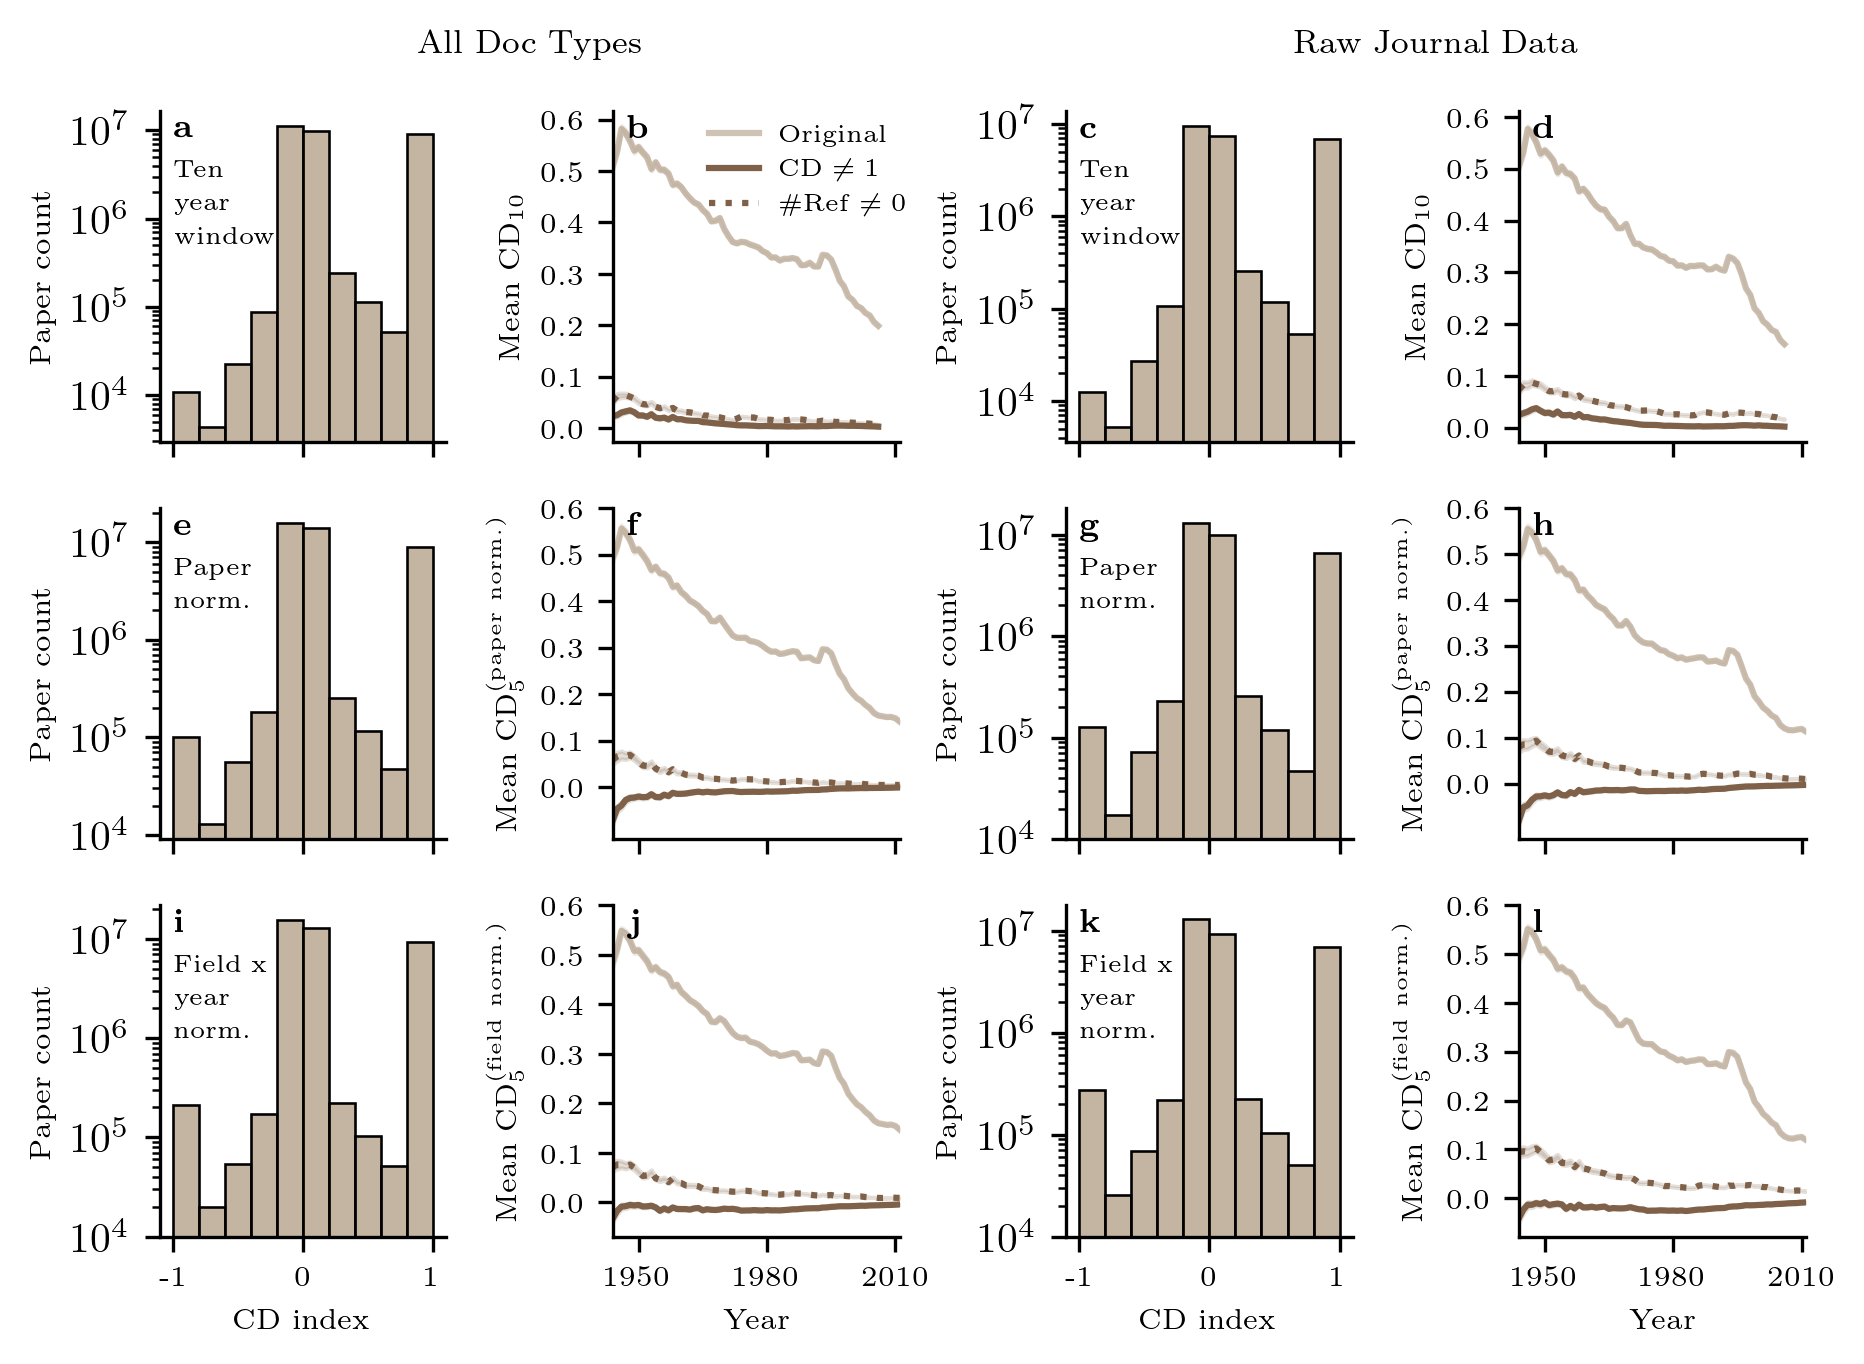

In [ ]:
### RUNTIME WARNING: This cell can take some time to run ~60 min ###

CONFIDENCE_INTERVAL=95 

### RECOMMENDATION: For faster runtime, set CONFIDENCE_INTERVAL to None ### 

figure, ax = plt.subplot_mosaic([['1', '1', '1', '.', '2', '2', '2'],
                                ['A', '.','B','.','C', '.', 'D'],
                                ['.', '.', '.', '.', '.', '.', '.'],
                                 ['E', '.','F','.','G', '.', 'H'],
                                ['.', '.', '.', '.', '.', '.', '.'],
                                 ['I', '.','J','.','K', '.', 'L'],
                                 ],
                                figsize=(7.08,6.69*3/4),
                                gridspec_kw = {'width_ratios':[1,0.3,1,0.3,1, 0.3,1],'height_ratios': [0.0, 1, 0.0, 1, 0.0, 1,]},
                                dpi = 300
                                )

plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams['text.usetex'] = True

#---------------------------------------------1---------------------------------------------
ax['1'].set_axis_off()
ax['1'].set_title('All Doc Types', fontsize=8)

#---------------------------------------------2---------------------------------------------
ax['2'].set_axis_off()
ax['2'].set_title('Raw Journal Data', fontsize=8)

#Set up a dictionary to more easily plot the different subplots
dic_hist={'A': ['cd_10', r'$\textbf{a}$'],
          'C': ['cd_10_raw', r'$\textbf{c}$'],
          'E': ['cd_5_paper_norm', r'$\textbf{e}$'],
          'G': ['cd_5_paper_norm_raw', r'$\textbf{g}$'],
          'I': ['cd_5_field_x_year_norm', r'$\textbf{i}$'],
          'K': ['cd_5_field_x_year_norm_raw', r'$\textbf{k}$']} 

dic_time={'B': ['cd_10', r'$\textbf{b}$', r"Mean $\mathrm{CD}_{10}$"],
          'D': ['cd_10_raw', r'$\textbf{d}$', r"Mean $\mathrm{CD}_{10}$"],
          'F': ['cd_5_paper_norm', r'$\textbf{f}$', r"Mean $\mathrm{CD}_{5}^{(\mathrm{paper~norm.)}}$"],
          'H': ['cd_5_paper_norm_raw', r'$\textbf{h}$', r"Mean $\mathrm{CD}_{5}^{(\mathrm{paper~norm.)}}$"],
          'J': ['cd_5_field_x_year_norm', r'$\textbf{j}$', r"Mean $\mathrm{CD}_{5}^{(\mathrm{field~norm.)}}$"],
          'L': ['cd_5_field_x_year_norm_raw', r'$\textbf{l}$', r"Mean $\mathrm{CD}_{5}^{(\mathrm{field~norm.)}}$"]}

axes_hist = ['A', 'C', 'E', 'G', 'I', 'K']
axes_time=['B', 'D', 'F', 'H', 'J', 'L']

for axis in axes_hist:
    hist=sns.histplot(x=dic_hist[axis][0],
             data=SciSciNet_df,
             bins=10,
             binrange=(-1,1), 
             stat="count",
             color ='#B09C8599',
             ax=ax[axis])

    ax[axis].set_yscale("log") 
    ax[axis].set_ylabel("Paper count",fontsize = 7)
    # Major y-ticks at 10^4, 10^5, 10^6, 10^7 
    yticks_major = [10**4, 10**5, 10**6, 10**7]
    ax[axis].set_yticks(yticks_major)
    ax[axis].get_yaxis().set_major_formatter(plt.ScalarFormatter())
    def log_format(x, pos):
        return f'$10^{{{int(np.log10(x))}}}$'

    ax[axis].get_yaxis().set_major_formatter(ticker.FuncFormatter(log_format))

    # Minor y-ticks for logarithmic scale
    yticks_minor = LogLocator(subs='all', numticks=12)
    ax[axis].yaxis.set_minor_locator(yticks_minor)
    ax[axis].text(0.05,0.92,dic_hist[axis][1], transform=ax[axis].transAxes,fontsize = 8)
    sns.despine(ax=ax[axis],left=False, bottom=False)

    if axis in ['I' , 'K']:
        ax[axis].set_xlabel(r'CD index', fontsize = 7)  
        ax[axis].set_xticks([-1, 0, 1],['-1', '0', '1'], fontsize = 7)
    else:
        ax[axis].set_xlabel('')
        ax[axis].set_xticks([-1, 0, 1],['', '', ''], fontsize = 7)
    del hist
    gc.collect()

for axis in axes_time:
    
    #Plot with no patents removed
    line1=sns.lineplot(data=SciSciNet_df,
            x='year',
            y=dic_time[axis][0],
            color = '#B09C8599',
            ci=CONFIDENCE_INTERVAL,
            ax = ax[axis])
          
    #Plot with papers with CD=1 removed

    #Mask to remove CD indices with value 1
    mask=SciSciNet_df[dic_time[axis][0]]!=1

    line2=sns.lineplot(data=SciSciNet_df[mask],
             x="Year",
             y=dic_time[axis][0],
             color = '#7E6148FF',
             ci=CONFIDENCE_INTERVAL,
             ax = ax[axis])

    #Plot with papers with zero references removed

    #Mask to remove patents with zero references
    mask=SciSciNet_df.references!=0

    line3=sns.lineplot(data=SciSciNet_df[mask],
             x="Year",
             y=dic_time[axis][0],
             color = '#7E6148FF',
             linestyle = ':',
             ci=CONFIDENCE_INTERVAL,
             ax = ax[axis])

    ax[axis].set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
    ax[axis].set_ylabel(dic_time[axis][2],fontsize = 7)
    ax[axis].set_yticks(np.arange(0,0.7,0.1)
                   )
    ax[axis].text(0.05,0.92,dic_time[axis][1], transform=ax[axis].transAxes,fontsize = 8)

    ax[axis].tick_params(axis='x', labelsize=7)
    ax[axis].tick_params(axis='y', labelsize=7)

    if axis in ['J' ,'L']:
        ax[axis].set_xlabel('Year', fontsize=7)
        ax[axis].set_xticks([1950, 1980, 2010], ['1950', '1980', '2010'], fontsize=7)
    else:
        ax[axis].set_xlabel('')
        ax[axis].set_xticks([1950, 1980, 2010], ['', '', ''], fontsize=7)


    sns.despine(ax=ax[axis],left=False, bottom=False)

#Add inset text to the histograms
ax['A'].text(0.05,0.8,'Ten', transform=ax['A'].transAxes,fontsize = 6)
ax['A'].text(0.05,0.7,'year', transform=ax['A'].transAxes,fontsize = 6)
ax['A'].text(0.05,0.6,'window', transform=ax['A'].transAxes,fontsize = 6)

ax['C'].text(0.05,0.8,'Ten', transform=ax['C'].transAxes,fontsize = 6)
ax['C'].text(0.05,0.7,'year', transform=ax['C'].transAxes,fontsize = 6)
ax['C'].text(0.05,0.6,'window', transform=ax['C'].transAxes,fontsize = 6)

ax['E'].text(0.05,0.8,'Paper', transform=ax['E'].transAxes,fontsize = 6)
ax['E'].text(0.05,0.7,'norm.', transform=ax['E'].transAxes,fontsize = 6)

ax['G'].text(0.05,0.8,'Paper', transform=ax['G'].transAxes,fontsize = 6)
ax['G'].text(0.05,0.7,'norm.', transform=ax['G'].transAxes,fontsize = 6)

ax['I'].text(0.05,0.8,'Field x', transform=ax['I'].transAxes,fontsize = 6)
ax['I'].text(0.05,0.7,'year', transform=ax['I'].transAxes,fontsize = 6)
ax['I'].text(0.05,0.6,'norm.', transform=ax['I'].transAxes,fontsize = 6)

ax['K'].text(0.05,0.8,'Field x', transform=ax['K'].transAxes,fontsize = 6)
ax['K'].text(0.05,0.7,'year', transform=ax['K'].transAxes,fontsize = 6)
ax['K'].text(0.05,0.6,'norm.', transform=ax['K'].transAxes,fontsize = 6)

legpatents = ax['B'].legend(labels=['original',
                                    '', 
                                    'minus CD=1',
                                    '',
                                    'minus zero ref.'],
                            loc = 'upper right',
                            fontsize = 6)
h = legpatents.get_lines()
legpatents_b = ax['B'].legend(handles = [h[0],h[1], h[2]],
                              labels=['Original', 
                                r'$\mathrm{CD} \neq 1$',
                               r'$\# \mathrm{Ref} \neq 0$'],
                              loc = (0.3,0.65),
                              fontsize = 6,
                              frameon=False
                              )

figure.savefig(config.OUTPUT_PATH+'RebuttalFigure_different_forward_citation_windows_and_normalized_measures.pdf')

plt.show()

# Supplementary Figure S17

The robustness checks in Park et al. (2023) failed to detect the consequences of the hidden outliers for the Web of Science data source.


To reproduce our findings, first download the replication data under the following link: https://zenodo.org/records/10619475. Then insert wos_df_rewiring.csv and wos_margins.csv in the data folder. Both data frames were created using all relevant data publicly
deposited by Park et al. (2023). 

In [35]:
#Load wos_df_rewiring
wos_df_rewiring = pd.read_csv(config.DATA_PATH+'wos_df_rewiring.csv')

#Load the wos_margins
wos_margins = pd.read_csv(config.DATA_PATH+'wos_margins.csv')

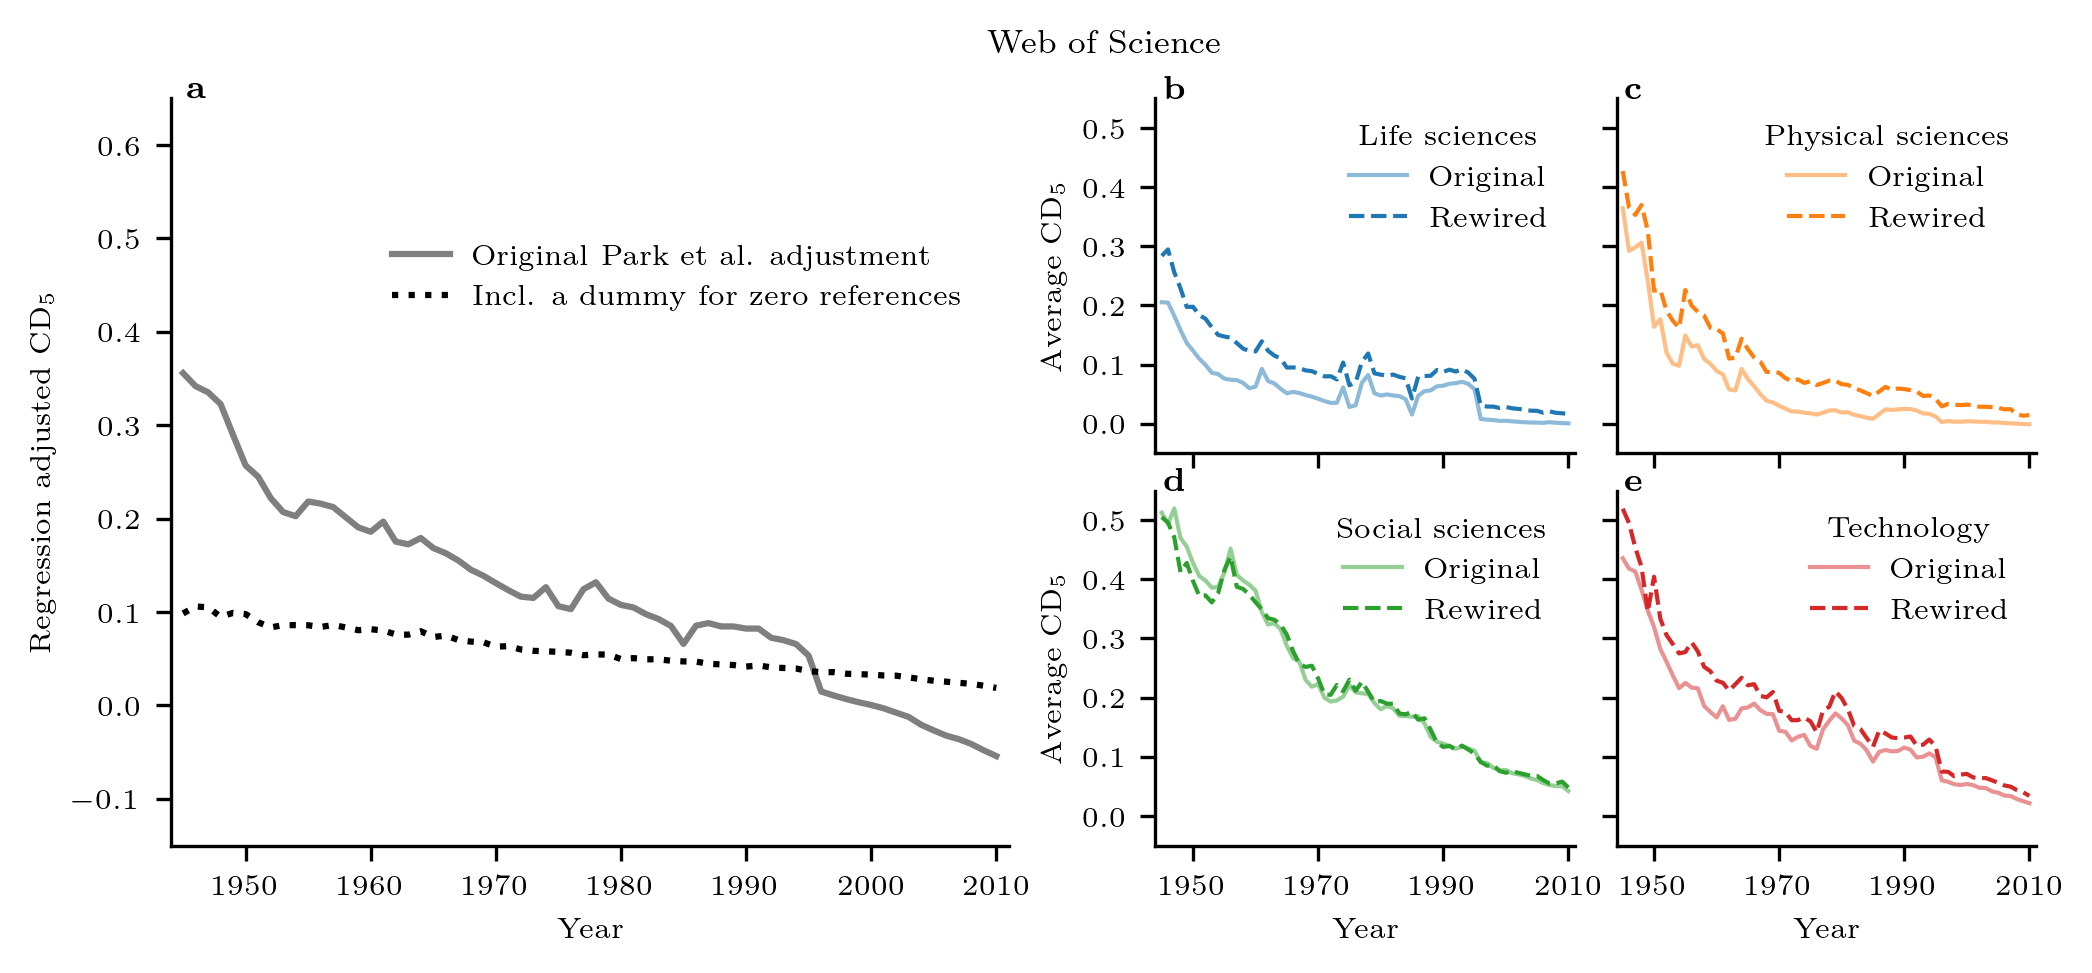

In [ ]:
Figure1, ax1 = plt.subplot_mosaic([
                                   ['T', 'T', 'T', 'T', 'T', 'T'],
                                   ['A','A','.', 'B', '.', 'C'],
                                   ['A','A','.', '.', '.', '.'],
                                   ['A','A','.', 'D', '.', 'E'],
                                   ],
                                  figsize=(7.08,6.69/2),gridspec_kw = {'width_ratios':[1,1,0.35, 1, 0.1,1],'height_ratios': [0.1,1, 0, 1]},dpi = 300)

plt.rcParams['legend.title_fontsize'] = 7
XTICKS=[1950,1970,1990,2010]
YTICKS=[0,0.1,0.2,0.3,0.4,0.5]

RESEARCH_AREA_ORDER = ["Life sciences and biomedicine",
                       "Physical sciences",
                       "Social sciences",
                       "Technology"]
###SET TITLE 

axis=ax1['T']
axis.text(0.5,1,'Web of Science',fontsize = 8, ha='center', va='center')
#Despine axis
sns.despine(ax=axis, left=True, bottom=True)
#Remove all axis ticks 
axis.set_xticks([])
#Remove all axis labels
axis.set_yticks([])

###REGRESSION

axis=ax1['A']
#Plot temporal regression adjusted CD_5 without dummy 
plt.rcParams['legend.title_fontsize'] = 7

sns.lineplot(data=wos_margins,
             x="year",
             y="margins_no_dummy",
             legend=False,
             color='black',
             alpha=0.5,
             ci=None,
             ax=axis)

#Plot temporal regression adjusted CD_5 with dummy

sns.lineplot(data=wos_margins,
             x="year",
             y="margins_with_dummy",
             legend=False,
             color='black',
             linestyle=':',
             ci=None,
             ax=axis)

axis.set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
axis.set_xticks(config.PAPER_YEAR_TICKS)
axis.set_ylim(-0.15, 0.65)
axis.set_xlabel("Year", fontsize=7)
axis.set_ylabel(r"Regression adjusted $\mathrm{CD}_5$", fontsize=7)
axis.text(0.02,1,r'$\textbf{a}$', transform=axis.transAxes,fontsize = 8)
#Set fontsize of labels in the plot
plt.setp(axis.get_xticklabels(), fontsize=7)
plt.setp(axis.get_yticklabels(), fontsize=7)
sns.despine(ax=axis,left=False, bottom=False)                                       

legpatents = axis.legend(labels=['Original Park et al. adjustment',
                                     '', 
                                     'Incl. a dummy for zero references ',
                                     ],
                             loc = 'upper right',
                             fontsize = 7
                             )
h = legpatents.get_lines()
legpatents_b = axis.legend(handles = [h[0],h[1]],
                               labels=['Original Park et al. adjustment', 
                                       'Incl. a dummy for zero references',
                                   ],
                               loc = (0.25,0.7),
                               frameon = False,
                               fontsize = 7
                               )


#SIMULATION

# Life Sciences and biomedicine

FIELD='Life sciences and biomedicine'
axis=ax1['B']

# plot
mask=wos_df_rewiring['field']==FIELD
sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="cd_5",
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             alpha=0.5,
             legend=False,
             ci=None,
             ax=axis)

sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="rewired_cd_5",
             linestyle='--',
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             legend=False,
             ci=None,
             ax=axis)

axis.set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
axis.set_xticks(XTICKS)
xticklabels = ['','','','']
axis.set_xticklabels(xticklabels)
axis.set_ylim(-0.05, 0.55)
axis.set_yticks(YTICKS)
axis.set_xlabel("", fontsize=7)
axis.set_ylabel(r"Average $\mathrm{CD}_5$", fontsize=7)
axis.text(0.02,1,r'$\textbf{b}$', transform=axis.transAxes,fontsize = 8)
#Set fontsize of ticks in the plot
plt.setp(axis.get_xticklabels(), fontsize=7)
plt.setp(axis.get_yticklabels(), fontsize=7)
sns.despine(ax=axis,left=False, bottom=False)                                       

legpatents = axis.legend(labels=['Observed',
                                     '', 
                                     'Rewired ',
                                     ],
                             loc = 'upper right',
                             fontsize = 7
                             )
h = legpatents.get_lines()
legpatents_b = axis.legend(handles = [h[0],h[1]],
                               labels=['Original', 
                                       'Rewired',
                                   ],
                               title='Life sciences',
                               loc = 'upper right',
                               frameon = False,
                               fontsize = 7
                               )

#Physical sciences

FIELD='Physical sciences'
axis=ax1['C']

# plot
mask=wos_df_rewiring['field']==FIELD
sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="cd_5",
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             alpha=0.5,
             legend=False,
             ci=None,
             ax=axis)

sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="rewired_cd_5",
             linestyle='--',
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             legend=False,
             ci=None,
             ax=axis)

axis.set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
axis.set_xticks(XTICKS)
xticklabels = ['','','','']
axis.set_xticklabels(xticklabels)
axis.set_ylim(-0.05, 0.55)
axis.set_yticks(YTICKS)
axis.set_xlabel("", fontsize=7)
#Set y ticks 
yticks = np.arange(0, 0.6, 0.1)
#Set y ticks labels
yticklabels = ['', '', '', '', '', '']
axis.set_yticklabels(yticklabels)
axis.set_ylabel("")
#Set fontsize of ticks in the plot
plt.setp(axis.get_xticklabels(), fontsize=7)
plt.setp(axis.get_yticklabels(), fontsize=7)
axis.text(0.02,1,r'$\textbf{c}$', transform=axis.transAxes,fontsize = 8)
sns.despine(ax=axis,left=False, bottom=False)                                       

legpatents = axis.legend(labels=['Observed',
                                     '', 
                                     'Rewired ',
                                     ],
                             loc = 'upper right',
                             fontsize = 7
                             )
h = legpatents.get_lines()
legpatents_b = axis.legend(handles = [h[0],h[1]],
                               labels=['Original', 
                                       'Rewired',
                                   ],
                               loc = 'upper right',
                               title=FIELD,
                               frameon = False,
                               fontsize = 7
                               )

# Social sciences

FIELD='Social sciences'
axis=ax1['D']

# plot
mask=wos_df_rewiring['field']==FIELD
sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="cd_5",
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             alpha=0.5,
             legend=False,
             ci=None,
             ax=axis)

sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="rewired_cd_5",
             linestyle='--',
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             legend=False,
             ci=None,
             ax=axis)

axis.set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
axis.set_xticks(XTICKS)
axis.set_ylim(-0.05, 0.55)
axis.set_yticks(YTICKS)
axis.set_xlabel("Year", fontsize=7)
axis.set_ylabel(r"Average $\mathrm{CD}_5$", fontsize=7)
#Set fontsize of ticks in the plot
plt.setp(axis.get_xticklabels(), fontsize=7)
plt.setp(axis.get_yticklabels(), fontsize=7)
axis.text(0.02,1,r'$\textbf{d}$', transform=axis.transAxes,fontsize = 8)
sns.despine(ax=axis,left=False, bottom=False)                                       

legpatents = axis.legend(labels=['Observed',
                                     '', 
                                     'Rewired ',
                                     ],
                             loc = 'upper right',
                             fontsize = 7
                             )
h = legpatents.get_lines()
legpatents_b = axis.legend(handles = [h[0],h[1]],
                               labels=['Original', 
                                       'Rewired',
                                   ],
                                title=FIELD,
                               loc = 'upper right',
                               frameon = False,
                               fontsize = 7
                               )

#Technology

FIELD='Technology'
axis=ax1['E']

# plot
mask=wos_df_rewiring['field']==FIELD
sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="cd_5",
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             alpha=0.5,
             legend=False,
             ci=None,
             ax=axis)

sns.lineplot(data=wos_df_rewiring[mask],
             x="year",
             y="rewired_cd_5",
             linestyle='--',
             hue="field",
             hue_order=RESEARCH_AREA_ORDER,
             linewidth=1,
             legend=False,
             ci=None,
             ax=axis)

axis.set_xlim(config.PAPER_MIN_YEAR, config.PAPER_MAX_YEAR)
axis.set_xticks(XTICKS)
axis.set_ylim(-0.05, 0.55)
axis.set_yticks(YTICKS)
#Set y ticks 
yticks = np.arange(0, 0.6, 0.1)
#Set y ticks labels
yticklabels = ['', '', '', '', '', '']
axis.set_yticklabels(yticklabels)
axis.set_xlabel("Year", fontsize=7)
axis.set_ylabel(r"")
#Set fontsize of ticks in the plot
plt.setp(axis.get_xticklabels(), fontsize=7)
plt.setp(axis.get_yticklabels(), fontsize=7)
axis.text(0.02,1,r'$\textbf{e}$', transform=axis.transAxes,fontsize = 8)
sns.despine(ax=axis,left=False, bottom=False)                                       

legpatents = axis.legend(labels=['Observed',
                                     '', 
                                     'Rewired ',
                                     ],
                             loc = 'upper right',
                             fontsize = 7
                             )
h = legpatents.get_lines()
legpatents_b = axis.legend(handles = [h[0],h[1]],
                           title=FIELD,
                               labels=['Original', 
                                       'Rewired',
                                   ],
                               loc = 'upper right',
                               frameon = False,
                               fontsize = 7
                               )


Figure1.tight_layout()
Figure1.subplots_adjust(hspace = 0.1,wspace = 0)
Figure1.savefig(config.OUTPUT_PATH + 'SupplementalFigure_Robustness_WoS.pdf',dpi = 300)